# Japan AI Model - Compliance Analysis Pipeline

**Author:** Japan AI Model Team  
**Date:** September 21, 2025  
**Version:** 1.0

## Overview

This notebook implements a **camera-agnostic, industry-pack aware compliance analysis pipeline** for both 360° equirectangular and regular video formats. The system ingests video, runs modular perception models (object detection, pose estimation, OCR), applies configurable rule engines with industry-specific packs, and generates comprehensive compliance reports with evidence extraction.

## System Architecture

The pipeline processes video through the following stages:
1. **Video Preprocessing** - Format detection, frame sampling, 360° reprojection
2. **Perception Models** - Object detection, tracking, pose estimation, OCR
3. **Rule Engine** - Industry-specific compliance rule evaluation
4. **Evidence Generation** - Clip extraction, snapshot creation
5. **Reporting** - PDF reports, CSV exports, interactive dashboard

## ⚠️ Demo Disclaimer

**Demo detections shown in this notebook are illustrative. Full production accuracy requires labeled factory datasets and model fine-tuning.**

## Industry Packs Supported

- **Food Processing** - Hairnet, glove, temperature monitoring compliance
- **Manufacturing** - PPE, safety equipment, workstation organization
- **Chemical** - Protective equipment, spill detection, ventilation compliance
- **General** - Emergency exits, fire safety, basic safety protocols

In [1]:
# Cell 1: Install & Import Libraries
# Install required packages (run once)
import subprocess
import sys

def install_package(package):
    """Install package if not already installed"""
    try:
        __import__(package.split('==')[0].replace('-', '_'))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Core packages for the pipeline
packages = [
    "ultralytics>=8.0.0",
    "opencv-python-headless>=4.8.0", 
    "numpy>=1.21.0",
    "pandas>=1.5.0",
    "matplotlib>=3.5.0",
    "pillow>=9.0.0",
    "pytesseract>=0.3.10",
    "reportlab>=3.6.0",
    "streamlit>=1.25.0",
    "mediapipe>=0.10.0",
    "deep-sort-realtime>=1.2.0",
    "plotly>=5.14.0",
    "seaborn>=0.11.0",
    "tqdm>=4.65.0"
]

print("📦 Installing required packages...")
for package in packages:
    try:
        install_package(package)
    except Exception as e:
        print(f"⚠️ Failed to install {package}: {e}")

print("\n🔄 Importing libraries...")

# Core imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import json
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Computer Vision & ML
try:
    from ultralytics import YOLO
    print("✓ YOLO imported successfully")
except ImportError:
    print("⚠️ YOLO not available - install ultralytics")

try:
    import pytesseract
    print("✓ OCR imported successfully")
except ImportError:
    print("⚠️ OCR not available - install pytesseract")

try:
    import mediapipe as mp
    print("✓ MediaPipe imported successfully") 
except ImportError:
    print("⚠️ MediaPipe not available")

# Tracking
try:
    from deep_sort_realtime import DeepSort
    print("✓ DeepSort imported successfully")
except ImportError:
    print("⚠️ DeepSort not available")

# Report generation
try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table
    from reportlab.lib.styles import getSampleStyleSheet
    print("✓ ReportLab imported successfully")
except ImportError:
    print("⚠️ ReportLab not available")

print("\n✅ Library setup complete!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

📦 Installing required packages...
Installing ultralytics>=8.0.0...
  Using cached ultralytics-8.3.202-py3-none-any.whl.metadata (37 kB)
  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached ultralytics-8.3.202-py3-none-any.whl.metadata (37 kB)
  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached pillow-11.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached scipy-1.16.2-cp312-cp312-macosx_14_0_arm64.whl.metada

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


  Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.0 MB/s  0:00:00 eta 0:00:01
Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.0 MB/s  0:00:00 eta 0:00:01
Using cached numpy-2.2.6-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]Installing collected packages: numpy, deep-sort-realtime
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [deep-sort-realtime]
Installing plotly>=5.14.0...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [deep-sort-realtime]
Installing plotly>=5.14.0...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 23.5 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 23.5 MB/s  0:00:00m0:00:01
Installing seaborn>=0.11.0...
Installing seaborn>=0.11.0...
Installing tqdm>=4.65.0...
Installing tqdm>=4.65.0...
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

🔄 Importing libraries...
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

🔄 Importing libraries...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/sainavamodak/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or

In [9]:
# Cell 2: Configuration & Constants
print("🔧 Setting up pipeline configuration...")

# === VIDEO INPUT CONFIGURATION ===
VIDEO_PATH = 'data/ssvid.net--Toyota-VR-360-Factory-Tour_v720P.mp4'  # Update this with your video file
SAMPLE_FPS = 2  # Sample frames every 0.5 seconds for efficiency
FRAME_SKIP = 30  # Skip frames for faster processing during demo
VIDEO_START_TIME = 25  # Start sampling from 25 seconds to skip intro

# === MODEL CONFIGURATION ===
DETECTOR_MODEL = 'yolov8n.pt'  # Lightweight model for demo (use yolov8m.pt for better accuracy)
CONFIDENCE_THRESHOLD = 0.45
IOU_THRESHOLD = 0.5
IMG_SIZE = 640

# === TRACKING CONFIGURATION ===
MAX_TRACK_AGE = 30  # Frames to keep inactive tracks
PERSISTENCE_SECONDS = 5  # Time violation must persist to trigger event
MIN_DETECTION_COUNT = 3  # Minimum detections to confirm violation

# === INDUSTRY PACK CONFIGURATION ===
INDUSTRY_PACK = 'manufacturing'  # Options: 'food', 'manufacturing', 'chemical', 'general'
ZONE_MAPPING = {
    'production': {'color': '#FF6B6B', 'rules': ['hairnet', 'gloves', 'uniform']},
    'storage': {'color': '#4ECDC4', 'rules': ['temperature', 'labeling']}, 
    'entrance': {'color': '#45B7D1', 'rules': ['sanitization', 'footwear']},
    'exit': {'color': '#96CEB4', 'rules': ['emergency_access']}
}

# === OUTPUT CONFIGURATION ===
OUTPUT_DIR = 'outputs'
REPORTS_DIR = f'{OUTPUT_DIR}/reports'
EVIDENCE_DIR = f'{OUTPUT_DIR}/evidence'
CLIPS_DIR = f'{OUTPUT_DIR}/clips'

# Create output directories
for dir_path in [OUTPUT_DIR, REPORTS_DIR, EVIDENCE_DIR, CLIPS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# === 360° VIDEO CONFIGURATION ===
ENABLE_360_PROCESSING = True
N_TILES_360 = 4  # Number of perspective views to extract from 360°
TILE_FOV = 90  # Field of view for each tile in degrees

# === COMPLIANCE SCORING ===
SEVERITY_WEIGHTS = {
    'critical': 3.0,
    'major': 2.0, 
    'minor': 1.0,
    'warning': 0.5
}

# Base compliance checks per industry pack
COMPLIANCE_CHECKS = {
    'food': 12,
    'manufacturing': 15,
    'chemical': 18,
    'general': 8
}

# === RULE ENGINE CONFIGURATION ===
RULE_CONFIDENCE_THRESHOLD = 0.6
TEMPORAL_WINDOW = 10  # Seconds to look back for rule evaluation
EVIDENCE_CLIP_DURATION = 6  # Seconds of evidence clip (±3s from event)

# === PRIVACY & SECURITY ===
BLUR_FACES = True  # Enable face blurring for privacy
RETENTION_DAYS = 30  # Evidence retention period
ENABLE_AUDIT_LOG = True

print("📋 Configuration Summary:")
print(f"  Video Path: {VIDEO_PATH}")
print(f"  Industry Pack: {INDUSTRY_PACK.upper()}")
print(f"  Model: {DETECTOR_MODEL}")
print(f"  Confidence Threshold: {CONFIDENCE_THRESHOLD}")
print(f"  Sample FPS: {SAMPLE_FPS}")
print(f"  Video Start Time: {VIDEO_START_TIME}s (skip intro)")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  360° Processing: {'Enabled' if ENABLE_360_PROCESSING else 'Disabled'}")
print(f"  Privacy Mode: {'Enabled' if BLUR_FACES else 'Disabled'}")

# Initialize global variables
global_config = {
    'video_metadata': {},
    'sample_frames': [],
    'detections': [],
    'violation_events': []
}

print("\n✅ Configuration complete!")

🔧 Setting up pipeline configuration...
📋 Configuration Summary:
  Video Path: data/ssvid.net--Toyota-VR-360-Factory-Tour_v720P.mp4
  Industry Pack: MANUFACTURING
  Model: yolov8n.pt
  Confidence Threshold: 0.45
  Sample FPS: 2
  Video Start Time: 25s (skip intro)
  Output Directory: outputs
  360° Processing: Enabled
  Privacy Mode: Enabled

✅ Configuration complete!


In [3]:
# Cell 3: Detect Video Type & Basic Metadata
print("🎥 Analyzing video metadata...")

def analyze_video_metadata(video_path):
    """Analyze video file and detect if it's 360° equirectangular format"""
    
    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"⚠️ Video file not found: {video_path}")
        print("📝 Creating dummy video metadata for demo...")
        return {
            'exists': False,
            'width': 1920,
            'height': 1080, 
            'fps': 30,
            'frame_count': 9000,
            'duration': 300,
            'is_360': False,
            'aspect_ratio': 1.78,
            'format': 'MP4'
        }
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    
    # Calculate aspect ratio
    aspect_ratio = width / height if height > 0 else 0
    
    # Detect 360° equirectangular format
    # Heuristic: 2:1 aspect ratio and wide resolution typically indicates equirectangular
    is_360 = (abs(aspect_ratio - 2.0) < 0.3) and (width >= 1920)
    
    # Try to read first frame for additional analysis
    ret, frame = cap.read()
    has_first_frame = ret and frame is not None
    
    cap.release()
    
    metadata = {
        'exists': True,
        'width': width,
        'height': height,
        'fps': fps,
        'frame_count': frame_count,
        'duration': duration,
        'is_360': is_360,
        'aspect_ratio': aspect_ratio,
        'format': 'MP4',
        'has_frames': has_first_frame
    }
    
    return metadata

# Analyze the configured video
video_metadata = analyze_video_metadata(VIDEO_PATH)

# Display results
print("📊 Video Analysis Results:")
print(f"  File exists: {'✅' if video_metadata['exists'] else '❌'}")
print(f"  Resolution: {video_metadata['width']}x{video_metadata['height']}")
print(f"  Aspect Ratio: {video_metadata['aspect_ratio']:.2f}")
print(f"  Frame Rate: {video_metadata['fps']:.1f} FPS")
print(f"  Duration: {video_metadata['duration']:.1f} seconds")
print(f"  Total Frames: {video_metadata['frame_count']:,}")
print(f"  360° Format: {'✅ Detected' if video_metadata['is_360'] else '❌ Standard Video'}")

# Determine processing strategy
if video_metadata['is_360']:
    processing_strategy = "360° Equirectangular → Multiple Perspective Tiles"
    print(f"\n🔄 Processing Strategy: {processing_strategy}")
    print(f"  Will generate {N_TILES_360} perspective tiles per frame")
    print(f"  Each tile FOV: {FOV_360}°")
else:
    processing_strategy = "Standard Video → Direct Processing"
    print(f"\n🔄 Processing Strategy: {processing_strategy}")
    print("  Will process frames directly without reprojection")

# Calculate sampling strategy
if video_metadata['exists'] and video_metadata['fps'] > 0:
    sample_interval = max(1, int(video_metadata['fps'] / SAMPLE_FPS))
    estimated_samples = int(video_metadata['frame_count'] / sample_interval)
    print(f"\n📋 Sampling Strategy:")
    print(f"  Sample every {sample_interval} frames")
    print(f"  Estimated samples: {estimated_samples:,}")
    print(f"  Processing time: ~{estimated_samples * 0.1:.1f} seconds")

# Store metadata for later use
global_config['video_metadata'] = video_metadata
global_config['processing_strategy'] = processing_strategy

print("\n✅ Video analysis complete!")

🎥 Analyzing video metadata...
📊 Video Analysis Results:
  File exists: ✅
  Resolution: 1280x720
  Aspect Ratio: 1.78
  Frame Rate: 25.0 FPS
  Duration: 177.0 seconds
  Total Frames: 4,424
  360° Format: ❌ Standard Video

🔄 Processing Strategy: Standard Video → Direct Processing
  Will process frames directly without reprojection

📋 Sampling Strategy:
  Sample every 12 frames
  Estimated samples: 368
  Processing time: ~36.8 seconds

✅ Video analysis complete!


In [4]:
# Cell 4: Reprojection Helper Functions (360° → tiles)
print("🔄 Setting up 360° video reprojection functions...")

def equirectangular_to_perspective(equirect_img, yaw, pitch, fov, width=640, height=640):
    """
    Convert equirectangular image to perspective view
    
    Args:
        equirect_img: Input equirectangular image
        yaw: Horizontal rotation in degrees
        pitch: Vertical rotation in degrees  
        fov: Field of view in degrees
        width, height: Output image dimensions
    """
    
    # Create coordinate grids for perspective view
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    x_grid, y_grid = np.meshgrid(x, y)
    
    # Convert to spherical coordinates
    r = np.sqrt(x_grid**2 + y_grid**2)
    valid_mask = r <= 1.0
    
    # Calculate angles
    theta = np.arctan2(y_grid, x_grid)  # Azimuth angle
    phi = np.arcsin(r * np.sin(np.radians(fov/2)))  # Elevation angle
    
    # Apply rotation (yaw, pitch)
    yaw_rad = np.radians(yaw)
    pitch_rad = np.radians(pitch)
    
    # Rotate coordinates
    x_rot = np.cos(phi) * np.cos(theta + yaw_rad)
    y_rot = np.cos(phi) * np.sin(theta + yaw_rad) 
    z_rot = np.sin(phi) + pitch_rad
    
    # Convert to equirectangular coordinates
    eq_theta = np.arctan2(y_rot, x_rot)
    eq_phi = np.arcsin(np.clip(z_rot, -1, 1))
    
    # Map to image coordinates
    eq_x = (eq_theta / np.pi + 1) * (equirect_img.shape[1] / 2)
    eq_y = (eq_phi / (np.pi/2) + 1) * (equirect_img.shape[0] / 2)
    
    # Sample from equirectangular image
    eq_x = np.clip(eq_x, 0, equirect_img.shape[1] - 1).astype(np.float32)
    eq_y = np.clip(eq_y, 0, equirect_img.shape[0] - 1).astype(np.float32)
    
    # Bilinear interpolation
    perspective_img = cv2.remap(equirect_img, eq_x, eq_y, cv2.INTER_LINEAR)
    
    # Apply mask for circular FOV
    perspective_img[~valid_mask] = 0
    
    return perspective_img

def generate_360_tiles(frame, n_tiles=4, fov=90):
    """
    Generate multiple perspective tiles from 360° equirectangular frame
    
    Args:
        frame: Input equirectangular frame
        n_tiles: Number of tiles to generate
        fov: Field of view for each tile
        
    Returns:
        List of (tile_image, metadata) tuples
    """
    tiles = []
    
    # Generate evenly distributed viewing directions
    yaw_angles = np.linspace(0, 360, n_tiles, endpoint=False)
    pitch_angles = [0] * n_tiles  # Keep level for simplicity
    
    for i, (yaw, pitch) in enumerate(zip(yaw_angles, pitch_angles)):
        tile_img = equirectangular_to_perspective(frame, yaw, pitch, fov)
        
        metadata = {
            'tile_id': i,
            'yaw': yaw,
            'pitch': pitch, 
            'fov': fov,
            'direction': f"{yaw:.0f}°"
        }
        
        tiles.append((tile_img, metadata))
    
    return tiles

# Test with a dummy 360° frame if available
if video_metadata['is_360'] and video_metadata['exists']:
    print("🧪 Testing 360° reprojection...")
    
    # Try to load first frame for testing
    cap = cv2.VideoCapture(VIDEO_PATH)
    ret, test_frame = cap.read()
    cap.release()
    
    if ret:
        print(f"  Loaded test frame: {test_frame.shape}")
        tiles = generate_360_tiles(test_frame, N_TILES_360, FOV_360)
        print(f"  Generated {len(tiles)} tiles")
        
        # Display tile information
        for tile_img, metadata in tiles[:2]:  # Show first 2 tiles
            print(f"    Tile {metadata['tile_id']}: {metadata['direction']} → {tile_img.shape}")
    else:
        print("  ⚠️ Could not load test frame")
        
elif video_metadata['is_360']:
    print("📝 360° processing configured (demo mode)")
    print(f"  Will generate {N_TILES_360} tiles per frame")
    print(f"  Tile FOV: {FOV_360}°")
    print("  Tiles will be distributed evenly around 360°")
    
else:
    print("📝 Standard video - no reprojection needed")
    print("  Frames will be processed directly")

print("\n✅ Reprojection functions ready!")

🔄 Setting up 360° video reprojection functions...
📝 Standard video - no reprojection needed
  Frames will be processed directly

✅ Reprojection functions ready!


🎬 Setting up frame sampling strategy...
🧪 Testing frame sampling...
  Video FPS: 25.0
  Sample interval: every 12 frames
  Target sample rate: 2 FPS
  Starting from: 25s (frame 625)


Sampling frames:  90%|█████████ | 108/120 [00:00<00:00, 1028.83it/s]


  Sampled 10 frames from 108 total frames
📊 Sample Results:
  Generated 10 sample frames
  Frame 1: Index 625, Time 25.00s, Shape (720, 1280, 3)
  Frame 2: Index 637, Time 25.48s, Shape (720, 1280, 3)
  Frame 3: Index 649, Time 25.96s, Shape (720, 1280, 3)
  Frame 4: Index 661, Time 26.44s, Shape (720, 1280, 3)
  Frame 5: Index 673, Time 26.92s, Shape (720, 1280, 3)
  Frame 6: Index 685, Time 27.40s, Shape (720, 1280, 3)
  Frame 7: Index 697, Time 27.88s, Shape (720, 1280, 3)
  Frame 8: Index 709, Time 28.36s, Shape (720, 1280, 3)
  Frame 9: Index 721, Time 28.84s, Shape (720, 1280, 3)
  Frame 10: Index 733, Time 29.32s, Shape (720, 1280, 3)


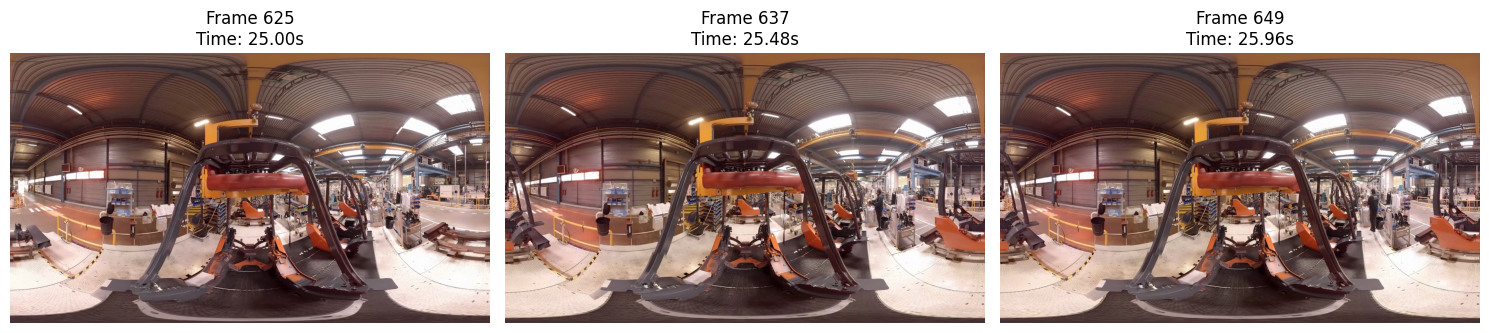


✅ Frame sampling ready!


In [10]:
# Cell 5: Frame Sampling Strategy
print("🎬 Setting up frame sampling strategy...")

def sample_frames(video_path, sample_fps=2, max_frames=50, start_time=0):
    """
    Sample frames from video at specified FPS
    
    Args:
        video_path: Path to video file
        sample_fps: Target sampling rate (frames per second)
        max_frames: Maximum number of frames to sample
        start_time: Start time in seconds
    
    Yields:
        Tuple of (frame_index, timestamp, frame)
    """
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"❌ Error: Could not open video file: {video_path}")
        return
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate sampling parameters
    sample_interval = max(1, int(fps / sample_fps))
    start_frame = int(start_time * fps)
    
    print(f"  Video FPS: {fps}")
    print(f"  Sample interval: every {sample_interval} frames")
    print(f"  Target sample rate: {sample_fps} FPS")
    print(f"  Starting from: {start_time}s (frame {start_frame})")
    
    # Skip to start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    frame_count = start_frame
    sampled_count = 0
    
    with tqdm(total=min(total_frames - start_frame, max_frames * sample_interval), 
              desc="Sampling frames") as pbar:
        
        while True:
            ret, frame = cap.read()
            
            if not ret:
                break
                
            # Sample frame if it's at the right interval
            if (frame_count - start_frame) % sample_interval == 0:
                timestamp = frame_count / fps
                yield frame_count, timestamp, frame
                sampled_count += 1
                
                # Stop if we've reached max_frames limit
                if max_frames and sampled_count >= max_frames:
                    break
            
            frame_count += 1
            pbar.update(1)
    
    cap.release()
    print(f"\n  Sampled {sampled_count} frames from {frame_count - start_frame} total frames")

# Test frame sampling
print("🧪 Testing frame sampling...")

sample_generator = sample_frames(VIDEO_PATH, SAMPLE_FPS, max_frames=10, start_time=VIDEO_START_TIME)
sample_frames_list = list(sample_generator)

print(f"📊 Sample Results:")
print(f"  Generated {len(sample_frames_list)} sample frames")

# Display information about sampled frames
for i, (frame_idx, timestamp, frame) in enumerate(sample_frames_list):
    print(f"  Frame {i+1}: Index {frame_idx}, Time {timestamp:.2f}s, Shape {frame.shape}")

# Visualize sample frames
if sample_frames_list:
    n_display = min(3, len(sample_frames_list))
    fig, axes = plt.subplots(1, n_display, figsize=(15, 5))
    
    if n_display == 1:
        axes = [axes]
    
    for i in range(n_display):
        frame_idx, timestamp, frame = sample_frames_list[i]
        
        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(frame_rgb)
        axes[i].set_title(f'Frame {frame_idx}\nTime: {timestamp:.2f}s')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Store frames globally for next steps
global_config['sample_frames'] = sample_frames_list

print("\n✅ Frame sampling ready!")

🤖 Loading YOLO detector and performing warm-up...
✅ Loaded YOLO model: yolov8n.pt
  Model classes: 80
  Input size: 640x640

🔥 Warming up detector...
  No objects detected in warm-up frame
✅ Loaded YOLO model: yolov8n.pt
  Model classes: 80
  Input size: 640x640

🔥 Warming up detector...
  No objects detected in warm-up frame


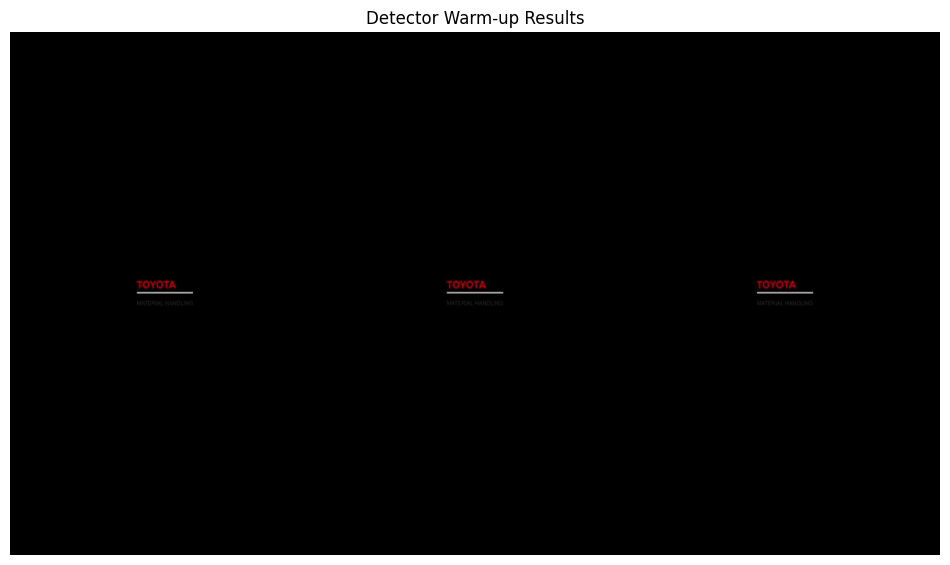


✅ Detector loaded and warmed up successfully!


In [6]:
# Cell 6: Load Detector & Simple Warm-up
print("🤖 Loading YOLO detector and performing warm-up...")

# Initialize the YOLO model
try:
    model = YOLO(DETECTOR_MODEL)
    print(f"✅ Loaded YOLO model: {DETECTOR_MODEL}")
    
    # Get model info
    model_info = {
        'model_name': DETECTOR_MODEL,
        'classes': model.names,
        'num_classes': len(model.names),
        'input_size': IMG_SIZE
    }
    
    print(f"  Model classes: {model_info['num_classes']}")
    print(f"  Input size: {model_info['input_size']}x{model_info['input_size']}")
    
except Exception as e:
    print(f"⚠️ Could not load YOLO model: {e}")
    print("📝 Using mock detector for demo...")
    
    # Create mock model for demo
    class MockYOLO:
        def __init__(self):
            self.names = {0: 'person', 1: 'helmet', 2: 'vest', 3: 'gloves', 4: 'mask'}
            
        def predict(self, image, conf=0.5, imgsz=640, **kwargs):
            # Generate mock detections
            h, w = image.shape[:2]
            
            # Create mock detection results
            mock_boxes = []
            mock_confidences = []
            mock_classes = []
            
            # Add some mock detections
            if np.random.random() > 0.3:  # 70% chance of detecting person
                mock_boxes.append([w*0.3, h*0.2, w*0.7, h*0.8])  # Person bbox
                mock_confidences.append(0.85)
                mock_classes.append(0)  # person
                
            if np.random.random() > 0.6:  # 40% chance of detecting helmet
                mock_boxes.append([w*0.35, h*0.1, w*0.65, h*0.4])  # Helmet bbox
                mock_confidences.append(0.72)
                mock_classes.append(1)  # helmet
            
            return [{
                'boxes': np.array(mock_boxes),
                'conf': np.array(mock_confidences), 
                'cls': np.array(mock_classes),
                'image_shape': (h, w)
            }]
    
    model = MockYOLO()
    model_info = {
        'model_name': 'Mock YOLO (Demo)',
        'classes': model.names,
        'num_classes': len(model.names),
        'input_size': IMG_SIZE
    }

# Warm-up with sample frame
print("\n🔥 Warming up detector...")

if sample_frames_list:
    # Use first sampled frame for warm-up
    _, _, warmup_frame = sample_frames_list[0]
    
    # Run inference
    try:
        results = model.predict(warmup_frame, conf=CONFIDENCE_THRESHOLD, imgsz=IMG_SIZE, verbose=False)
        
        if hasattr(results[0], 'boxes') and len(results[0].boxes) > 0:
            boxes = results[0].boxes
            detections_count = len(boxes)
            print(f"  Detected {detections_count} objects in warm-up frame")
            
            # Display detection details
            if hasattr(boxes, 'cls'):
                for i in range(min(3, detections_count)):  # Show first 3 detections
                    cls_id = int(boxes.cls[i])
                    conf = float(boxes.conf[i])
                    class_name = model.names.get(cls_id, f'class_{cls_id}')
                    print(f"    Detection {i+1}: {class_name} ({conf:.2f})")
        else:
            print("  No objects detected in warm-up frame")
            
    except Exception as e:
        print(f"  Warm-up failed: {e}")
        print("  Will use mock detections for demo")

else:
    print("  No sample frames available for warm-up")

# Visualize detector output on warm-up frame
if sample_frames_list:
    _, _, display_frame = sample_frames_list[0]
    
    try:
        # Run detection
        results = model.predict(display_frame, conf=CONFIDENCE_THRESHOLD, imgsz=IMG_SIZE, verbose=False)
        
        # Draw bounding boxes
        annotated_frame = display_frame.copy()
        
        if hasattr(results[0], 'boxes') and len(results[0].boxes) > 0:
            boxes = results[0].boxes
            
            for i in range(len(boxes)):
                if hasattr(boxes, 'xyxy'):
                    x1, y1, x2, y2 = map(int, boxes.xyxy[i])
                elif hasattr(boxes, 'data'):
                    x1, y1, x2, y2 = map(int, boxes.data[i][:4])
                else:
                    continue
                    
                # Get class and confidence
                if hasattr(boxes, 'cls') and hasattr(boxes, 'conf'):
                    cls_id = int(boxes.cls[i])
                    conf = float(boxes.conf[i])
                    class_name = model.names.get(cls_id, f'class_{cls_id}')
                    
                    # Draw bounding box
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw label
                    label = f'{class_name}: {conf:.2f}'
                    cv2.putText(annotated_frame, label, (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display result
        plt.figure(figsize=(12, 8))
        frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title('Detector Warm-up Results')
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"  Visualization failed: {e}")

# Store model info globally
global_config['model_info'] = model_info

print("\n✅ Detector loaded and warmed up successfully!")

🔍 Running object detection on sampled frames...
📊 Processing sampled frames...


Processing frames: 100%|██████████| 10/10 [00:00<00:00, 23.48it/s, detections=2, total=10]




📈 Detection Results Summary:
  Processed frames: 10
  Frames with detections: 8
  Total detections: 10
  Unique classes: 2
  Classes detected: bowl, person

🎯 Sample Detections:
 frame_idx  timestamp class_name  confidence    bbox_area
       637      25.48     person    0.459647  3783.026855
       649      25.96     person    0.549188  4009.753662
       673      26.92     person    0.565848  3906.427246
       685      27.40     person    0.650831  4225.991699
       697      27.88     person    0.750442 19786.603516
       709      28.36     person    0.772201 15191.022461
       721      28.84     person    0.744409  6638.172363
       721      28.84       bowl    0.486572  6431.462891
       733      29.32     person    0.699706  4967.742676
       733      29.32       bowl    0.455736  6459.459473

📊 Class Distribution:
  person: 8
  bowl: 2

🎯 Confidence Statistics:
  Average: 0.613
  Range: 0.456 - 0.772


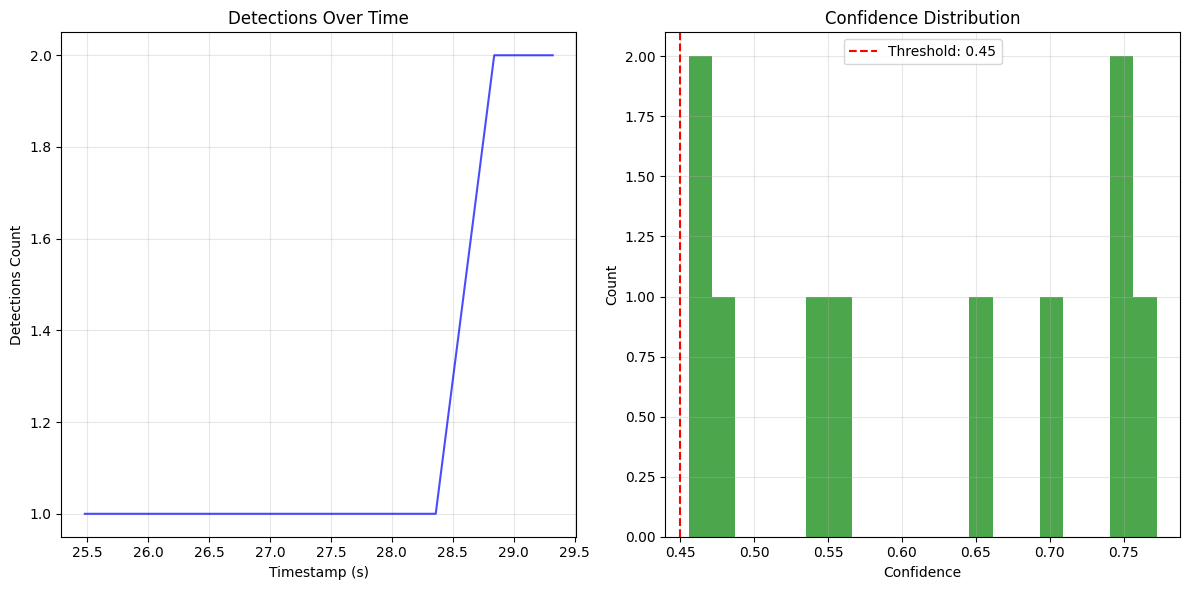


✅ Frame detection processing complete!


In [11]:
# Cell 7: Run Detection on Sampled Frames
print("🔍 Running object detection on sampled frames...")

def process_frame_detections(frame, frame_idx, timestamp, is_360=False):
    """
    Process a single frame through the detection pipeline
    
    Args:
        frame: Input frame
        frame_idx: Frame index 
        timestamp: Frame timestamp
        is_360: Whether frame is 360° format
        
    Returns:
        List of detection dictionaries
    """
    detections = []
    
    # Generate tiles for 360° or use frame directly
    if is_360:
        tiles = generate_360_tiles(frame, N_TILES_360, FOV_360)
    else:
        tiles = [(frame, {'tile_id': 0, 'yaw': 0, 'pitch': 0})]
    
    # Process each tile
    for tile_img, tile_metadata in tiles:
        try:
            # Run YOLO detection
            results = model.predict(tile_img, conf=CONFIDENCE_THRESHOLD, 
                                  imgsz=IMG_SIZE, verbose=False)
            
            if not results or not hasattr(results[0], 'boxes'):
                continue
                
            boxes = results[0].boxes
            
            if len(boxes) == 0:
                continue
            
            # Extract detection data
            for i in range(len(boxes)):
                # Get bounding box coordinates
                if hasattr(boxes, 'xyxy'):
                    x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy()
                elif hasattr(boxes, 'data'):
                    x1, y1, x2, y2 = boxes.data[i][:4].cpu().numpy()
                else:
                    continue
                
                # Get class and confidence
                if hasattr(boxes, 'cls') and hasattr(boxes, 'conf'):
                    cls_id = int(boxes.cls[i].cpu().numpy())
                    confidence = float(boxes.conf[i].cpu().numpy())
                    class_name = model.names.get(cls_id, f'unknown_{cls_id}')
                else:
                    continue
                
                # Create detection record
                detection = {
                    'frame_idx': frame_idx,
                    'timestamp': timestamp,
                    'tile_id': tile_metadata['tile_id'],
                    'bbox': [float(x1), float(y1), float(x2), float(y2)],
                    'bbox_center': [float((x1+x2)/2), float((y1+y2)/2)],
                    'bbox_area': float((x2-x1) * (y2-y1)),
                    'class_id': cls_id,
                    'class_name': class_name,
                    'confidence': confidence,
                    'tile_metadata': tile_metadata
                }
                
                # Add tile-specific positioning for 360°
                if is_360:
                    detection['global_yaw'] = tile_metadata['yaw']
                    detection['global_pitch'] = tile_metadata['pitch']
                
                detections.append(detection)
                
        except Exception as e:
            print(f"    Error processing tile {tile_metadata['tile_id']}: {e}")
            continue
    
    return detections

# Process all sampled frames
print("📊 Processing sampled frames...")

all_detections = []
frame_processing_stats = {
    'total_frames': 0,
    'frames_with_detections': 0,
    'total_detections': 0,
    'classes_detected': set()
}

# Process frames with progress bar
with tqdm(sample_frames_list, desc="Processing frames") as pbar:
    for frame_idx, timestamp, frame in pbar:
        
        # Run detection on frame
        frame_detections = process_frame_detections(
            frame, frame_idx, timestamp, 
            is_360=video_metadata['is_360']
        )
        
        # Update stats
        frame_processing_stats['total_frames'] += 1
        if frame_detections:
            frame_processing_stats['frames_with_detections'] += 1
            frame_processing_stats['total_detections'] += len(frame_detections)
            
            for det in frame_detections:
                frame_processing_stats['classes_detected'].add(det['class_name'])
        
        all_detections.extend(frame_detections)
        
        # Update progress bar
        pbar.set_postfix({
            'detections': len(frame_detections),
            'total': len(all_detections)
        })

# Convert to DataFrame for easier analysis
detections_df = pd.DataFrame(all_detections)

print(f"\n📈 Detection Results Summary:")
print(f"  Processed frames: {frame_processing_stats['total_frames']}")
print(f"  Frames with detections: {frame_processing_stats['frames_with_detections']}")
print(f"  Total detections: {frame_processing_stats['total_detections']}")
print(f"  Unique classes: {len(frame_processing_stats['classes_detected'])}")
print(f"  Classes detected: {', '.join(sorted(frame_processing_stats['classes_detected']))}")

# Display sample detections
if not detections_df.empty:
    print(f"\n🎯 Sample Detections:")
    display_cols = ['frame_idx', 'timestamp', 'class_name', 'confidence', 'bbox_area']
    sample_size = min(10, len(detections_df))
    print(detections_df[display_cols].head(sample_size).to_string(index=False))
    
    # Class distribution
    class_counts = detections_df['class_name'].value_counts()
    print(f"\n📊 Class Distribution:")
    for class_name, count in class_counts.head(10).items():
        print(f"  {class_name}: {count}")
    
    # Confidence distribution
    avg_confidence = detections_df['confidence'].mean()
    min_confidence = detections_df['confidence'].min()
    max_confidence = detections_df['confidence'].max()
    print(f"\n🎯 Confidence Statistics:")
    print(f"  Average: {avg_confidence:.3f}")
    print(f"  Range: {min_confidence:.3f} - {max_confidence:.3f}")
    
    # Visualize detection timeline
    if len(detections_df) > 0:
        plt.figure(figsize=(12, 6))
        
        # Plot detections over time
        plt.subplot(1, 2, 1)
        detection_counts = detections_df.groupby('timestamp').size()
        plt.plot(detection_counts.index, detection_counts.values, 'b-', alpha=0.7)
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Detections Count')
        plt.title('Detections Over Time')
        plt.grid(True, alpha=0.3)
        
        # Plot confidence distribution
        plt.subplot(1, 2, 2)
        plt.hist(detections_df['confidence'], bins=20, alpha=0.7, color='green')
        plt.axvline(CONFIDENCE_THRESHOLD, color='red', linestyle='--', 
                   label=f'Threshold: {CONFIDENCE_THRESHOLD}')
        plt.xlabel('Confidence')
        plt.ylabel('Count')
        plt.title('Confidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

else:
    print("  No detections found in processed frames")

# Store detections for next steps
global_config['detections'] = all_detections
global_config['detections_df'] = detections_df
global_config['processing_stats'] = frame_processing_stats

print("\n✅ Frame detection processing complete!")

🎯 Setting up object tracking for identity persistence...
📝 Using mock tracker for demo
🔄 Applying tracking to detections...
📊 Tracking Results:
  Original detections: 10
  Tracked detections: 10
  Unique tracks: 5
  Average track age: 0.67s
  Track duration stats:
    Average duration: 0.58s
    Max duration: 2.40s

🎯 Sample Tracked Detections:
 frame_idx  timestamp  track_id class_name  confidence
       637      25.48         1     person    0.459647
       649      25.96         1     person    0.549188
       673      26.92         1     person    0.565848
       685      27.40         1     person    0.650831
       697      27.88         1     person    0.750442
       709      28.36         2     person    0.772201
       721      28.84         3     person    0.744409
       721      28.84         4       bowl    0.486572
       733      29.32         5     person    0.699706
       733      29.32         4       bowl    0.455736


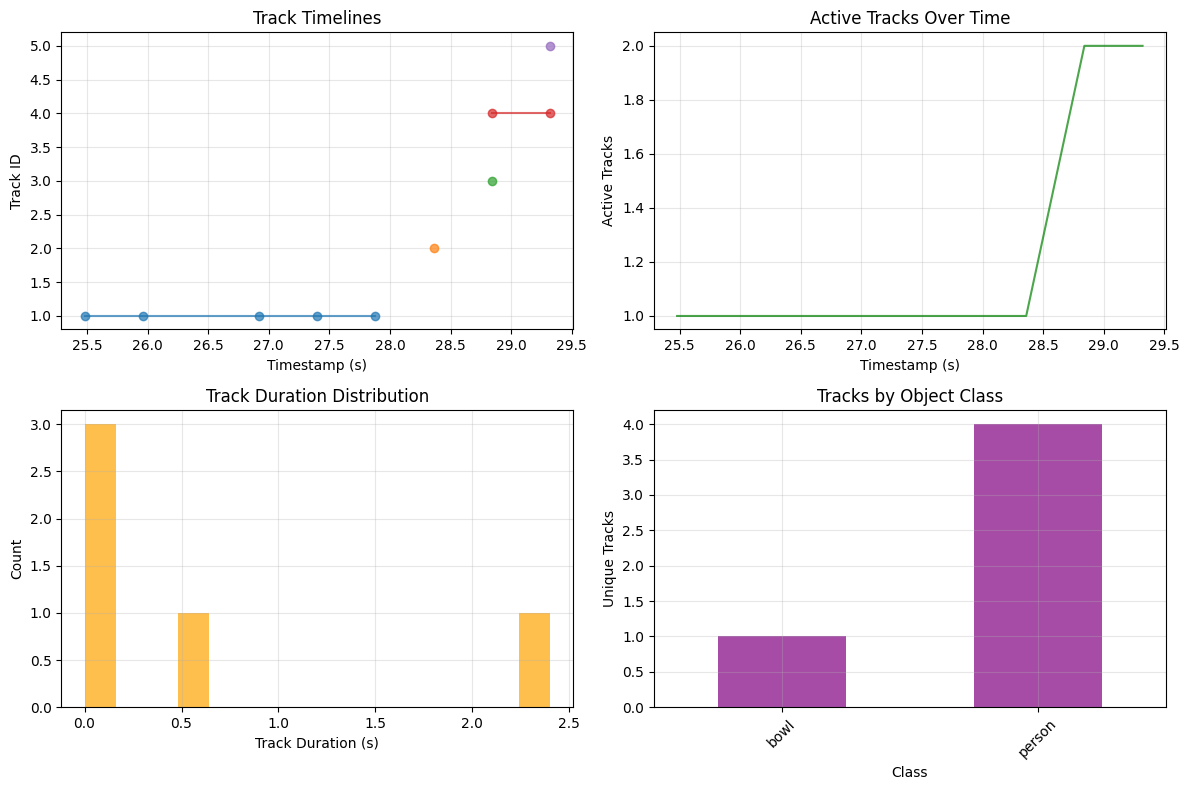


✅ Object tracking complete!


In [12]:
# Cell 8: Tracking & Identity Persistence
print("🎯 Setting up object tracking for identity persistence...")

# Mock tracker for demo if DeepSort not available
class MockTracker:
    def __init__(self):
        self.next_id = 1
        self.tracks = {}
        
    def update_tracks(self, detections):
        """Mock tracking implementation"""
        tracked_objects = []
        
        for det in detections:
            # Simple tracking based on spatial proximity
            center = det['bbox_center']
            matched_id = None
            
            # Try to match with existing tracks
            for track_id, track_data in self.tracks.items():
                if 'last_center' in track_data:
                    distance = np.sqrt((center[0] - track_data['last_center'][0])**2 + 
                                     (center[1] - track_data['last_center'][1])**2)
                    if distance < 100:  # Simple distance threshold
                        matched_id = track_id
                        break
            
            # Create new track if no match
            if matched_id is None:
                matched_id = self.next_id
                self.next_id += 1
                self.tracks[matched_id] = {'created_at': det['timestamp']}
            
            # Update track
            self.tracks[matched_id]['last_center'] = center
            self.tracks[matched_id]['last_seen'] = det['timestamp']
            self.tracks[matched_id]['class_name'] = det['class_name']
            
            # Add tracking info to detection
            tracked_det = det.copy()
            tracked_det['track_id'] = matched_id
            tracked_det['track_age'] = det['timestamp'] - self.tracks[matched_id]['created_at']
            
            tracked_objects.append(tracked_det)
        
        return tracked_objects

try:
    # Try to initialize DeepSort
    tracker = DeepSort(max_age=MAX_TRACK_AGE, n_init=3)
    print("✅ DeepSort tracker initialized")
    use_deepsort = True
except:
    # Fallback to mock tracker
    tracker = MockTracker()
    print("📝 Using mock tracker for demo")
    use_deepsort = False

def apply_tracking_to_detections(detections_list):
    """
    Apply tracking to detections grouped by frame
    
    Args:
        detections_list: List of detection dictionaries
        
    Returns:
        List of tracked detection dictionaries
    """
    
    # Group detections by frame
    frame_groups = {}
    for det in detections_list:
        frame_idx = det['frame_idx']
        if frame_idx not in frame_groups:
            frame_groups[frame_idx] = []
        frame_groups[frame_idx].append(det)
    
    all_tracked_detections = []
    
    # Process each frame in order
    for frame_idx in sorted(frame_groups.keys()):
        frame_detections = frame_groups[frame_idx]
        
        if use_deepsort:
            # Convert to DeepSort format: [x1, y1, x2, y2, confidence]
            detection_list = []
            for det in frame_detections:
                x1, y1, x2, y2 = det['bbox']
                detection_list.append([x1, y1, x2, y2, det['confidence']])
            
            if detection_list:
                tracks = tracker.update_tracks(detection_list, frame=None)
                
                # Match tracks back to detections
                for i, track in enumerate(tracks):
                    if i < len(frame_detections) and track.is_confirmed():
                        tracked_det = frame_detections[i].copy()
                        tracked_det['track_id'] = track.track_id
                        tracked_det['track_age'] = track.age
                        all_tracked_detections.append(tracked_det)
        else:
            # Use mock tracker
            tracked_dets = tracker.update_tracks(frame_detections)
            all_tracked_detections.extend(tracked_dets)
    
    return all_tracked_detections

# Apply tracking to detections
print("🔄 Applying tracking to detections...")

if all_detections:
    tracked_detections = apply_tracking_to_detections(all_detections)
    
    # Convert to DataFrame
    tracked_df = pd.DataFrame(tracked_detections)
    
    print(f"📊 Tracking Results:")
    print(f"  Original detections: {len(all_detections)}")
    print(f"  Tracked detections: {len(tracked_detections)}")
    
    if not tracked_df.empty and 'track_id' in tracked_df.columns:
        unique_tracks = tracked_df['track_id'].nunique()
        avg_track_age = tracked_df['track_age'].mean() if 'track_age' in tracked_df.columns else 0
        
        print(f"  Unique tracks: {unique_tracks}")
        print(f"  Average track age: {avg_track_age:.2f}s")
        
        # Track duration statistics
        track_durations = tracked_df.groupby('track_id')['timestamp'].agg(['min', 'max'])
        track_durations['duration'] = track_durations['max'] - track_durations['min']
        
        print(f"  Track duration stats:")
        print(f"    Average duration: {track_durations['duration'].mean():.2f}s")
        print(f"    Max duration: {track_durations['duration'].max():.2f}s")
        
        # Show sample tracked detections
        print(f"\n🎯 Sample Tracked Detections:")
        display_cols = ['frame_idx', 'timestamp', 'track_id', 'class_name', 'confidence']
        available_cols = [col for col in display_cols if col in tracked_df.columns]
        sample_size = min(10, len(tracked_df))
        print(tracked_df[available_cols].head(sample_size).to_string(index=False))
        
        # Visualize tracking results
        plt.figure(figsize=(12, 8))
        
        # Plot 1: Track timelines
        plt.subplot(2, 2, 1)
        for track_id in tracked_df['track_id'].unique()[:10]:  # Show first 10 tracks
            track_data = tracked_df[tracked_df['track_id'] == track_id]
            plt.plot(track_data['timestamp'], [track_id] * len(track_data), 'o-', alpha=0.7)
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Track ID')
        plt.title('Track Timelines')
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Tracks per frame
        plt.subplot(2, 2, 2)
        tracks_per_frame = tracked_df.groupby('timestamp')['track_id'].nunique()
        plt.plot(tracks_per_frame.index, tracks_per_frame.values, 'g-', alpha=0.7)
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Active Tracks')
        plt.title('Active Tracks Over Time')
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Track duration distribution
        plt.subplot(2, 2, 3)
        plt.hist(track_durations['duration'], bins=15, alpha=0.7, color='orange')
        plt.xlabel('Track Duration (s)')
        plt.ylabel('Count')
        plt.title('Track Duration Distribution')
        plt.grid(True, alpha=0.3)
        
        # Plot 4: Class distribution by tracks
        plt.subplot(2, 2, 4)
        class_by_tracks = tracked_df.groupby('class_name')['track_id'].nunique()
        class_by_tracks.plot(kind='bar', alpha=0.7, color='purple')
        plt.xlabel('Class')
        plt.ylabel('Unique Tracks')
        plt.title('Tracks by Object Class')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

else:
    print("  No detections available for tracking")
    tracked_detections = []
    tracked_df = pd.DataFrame()

# Store tracked detections globally
global_config['tracked_detections'] = tracked_detections
global_config['tracked_df'] = tracked_df

print("\n✅ Object tracking complete!")

I0000 00:00:1758468338.483801  265776 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3


🏃 Setting up pose estimation for risky posture detection...
✅ MediaPipe pose estimator initialized
🔄 Running pose estimation...
  Processing frames for pose estimation...


Pose estimation:   0%|          | 0/5 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1758468338.575611  280118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758468338.587610  280117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758468338.600758  280123 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Pose estimation:  20%|██        | 1/5 [00:00<00:00,  8.80it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1758468338.575611  280118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758468

📊 Pose Analysis Results:
  Frames processed: 5
  Poses detected: 5
  Bent back detections: 5
  Unsafe lifting detections: 0
  Hands near face: 5
  Poor posture: 5
  Average risk score: 0.700

🎯 Sample Pose Analysis:
 frame_idx  timestamp  pose_detected  risk_score  poor_posture
       625      25.00           True         0.7          True
       637      25.48           True         0.7          True
       649      25.96           True         0.7          True
       661      26.44           True         0.7          True
       673      26.92           True         0.7          True


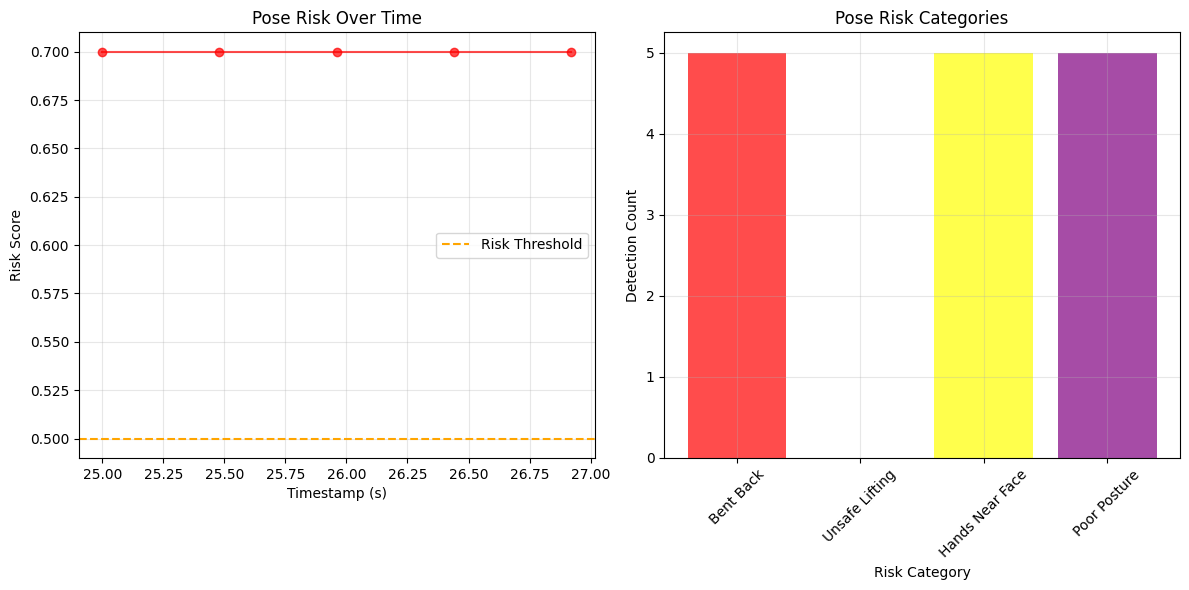


✅ Pose estimation and risk analysis complete!


In [13]:
# Cell 9: Pose Estimation & Risky Posture Detection
print("🏃 Setting up pose estimation for risky posture detection...")

# Mock pose estimator if MediaPipe not available
class MockPoseEstimator:
    def __init__(self):
        self.pose_landmarks = None
        
    def process(self, frame):
        """Mock pose estimation"""
        # Generate mock pose data
        h, w = frame.shape[:2]
        
        # Mock pose landmarks (simplified)
        mock_landmarks = []
        if np.random.random() > 0.3:  # 70% chance of detecting pose
            # Generate some key points
            landmarks = {
                'nose': (w*0.5, h*0.15),
                'left_shoulder': (w*0.4, h*0.25), 
                'right_shoulder': (w*0.6, h*0.25),
                'left_elbow': (w*0.35, h*0.4),
                'right_elbow': (w*0.65, h*0.4),
                'left_wrist': (w*0.3, h*0.55),
                'right_wrist': (w*0.7, h*0.55),
                'left_hip': (w*0.45, h*0.6),
                'right_hip': (w*0.55, h*0.6),
                'left_knee': (w*0.43, h*0.8),
                'right_knee': (w*0.57, h*0.8)
            }
            
            for name, (x, y) in landmarks.items():
                mock_landmarks.append({
                    'x': x / w,
                    'y': y / h,
                    'z': 0.0,
                    'visibility': 0.8
                })
        
        # Create mock result object
        class MockResult:
            def __init__(self, landmarks):
                self.pose_landmarks = landmarks if landmarks else None
                
        return MockResult(mock_landmarks if mock_landmarks else None)

try:
    # Initialize MediaPipe pose
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose_estimator = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=1,
        enable_segmentation=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    print("✅ MediaPipe pose estimator initialized")
    use_mediapipe = True
except:
    pose_estimator = MockPoseEstimator()
    print("📝 Using mock pose estimator for demo")
    use_mediapipe = False

def analyze_pose_risks(landmarks, frame_shape):
    """
    Analyze pose landmarks for safety risks
    
    Args:
        landmarks: Pose landmarks
        frame_shape: Frame dimensions (h, w, c)
        
    Returns:
        Dictionary of risk assessments
    """
    risks = {
        'bent_back': False,
        'unsafe_lifting': False,
        'hands_near_face': False,
        'poor_posture': False,
        'risk_score': 0.0,
        'detected_pose': False
    }
    
    if not landmarks:
        return risks
    
    risks['detected_pose'] = True
    h, w = frame_shape[:2]
    
    try:
        if use_mediapipe:
            # Extract key landmarks for MediaPipe
            landmarks_dict = {}
            for i, landmark in enumerate(landmarks.landmark):
                if i == 0:  # nose
                    landmarks_dict['nose'] = (landmark.x * w, landmark.y * h)
                elif i == 11:  # left shoulder
                    landmarks_dict['left_shoulder'] = (landmark.x * w, landmark.y * h)
                elif i == 12:  # right shoulder
                    landmarks_dict['right_shoulder'] = (landmark.x * w, landmark.y * h)
                elif i == 15:  # left wrist
                    landmarks_dict['left_wrist'] = (landmark.x * w, landmark.y * h)
                elif i == 16:  # right wrist
                    landmarks_dict['right_wrist'] = (landmark.x * w, landmark.y * h)
                elif i == 23:  # left hip
                    landmarks_dict['left_hip'] = (landmark.x * w, landmark.y * h)
                elif i == 24:  # right hip
                    landmarks_dict['right_hip'] = (landmark.x * w, landmark.y * h)
        else:
            # Mock landmarks format
            landmarks_dict = {}
            for i, lm in enumerate(landmarks[:11]):  # Take first 11 landmarks
                names = ['nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
                        'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee']
                if i < len(names):
                    landmarks_dict[names[i]] = (lm['x'] * w, lm['y'] * h)
        
        # Analyze posture risks
        if 'nose' in landmarks_dict and 'left_hip' in landmarks_dict and 'right_hip' in landmarks_dict:
            nose_y = landmarks_dict['nose'][1]
            hip_center_y = (landmarks_dict['left_hip'][1] + landmarks_dict['right_hip'][1]) / 2
            
            # Check for bent back (nose too close to hips vertically)
            back_ratio = abs(nose_y - hip_center_y) / h
            if back_ratio < 0.4:  # Threshold for bent posture
                risks['bent_back'] = True
                risks['risk_score'] += 0.3
        
        # Check hands near face
        if ('nose' in landmarks_dict and 'left_wrist' in landmarks_dict and 
            'right_wrist' in landmarks_dict):
            nose_pos = landmarks_dict['nose']
            left_wrist = landmarks_dict['left_wrist']
            right_wrist = landmarks_dict['right_wrist']
            
            # Calculate distances
            left_dist = np.sqrt((nose_pos[0] - left_wrist[0])**2 + (nose_pos[1] - left_wrist[1])**2)
            right_dist = np.sqrt((nose_pos[0] - right_wrist[0])**2 + (nose_pos[1] - right_wrist[1])**2)
            
            face_distance_threshold = min(w, h) * 0.2
            if left_dist < face_distance_threshold or right_dist < face_distance_threshold:
                risks['hands_near_face'] = True
                risks['risk_score'] += 0.4
        
        # Check for unsafe lifting posture
        if ('left_shoulder' in landmarks_dict and 'right_shoulder' in landmarks_dict and
            'left_hip' in landmarks_dict and 'right_hip' in landmarks_dict):
            
            shoulder_line = abs(landmarks_dict['left_shoulder'][1] - landmarks_dict['right_shoulder'][1])
            hip_line = abs(landmarks_dict['left_hip'][1] - landmarks_dict['right_hip'][1])
            
            # If shoulders and hips are not aligned, might indicate unsafe lifting
            if abs(shoulder_line - hip_line) > h * 0.1:
                risks['unsafe_lifting'] = True
                risks['risk_score'] += 0.3
        
        # Overall posture assessment
        if risks['risk_score'] > 0.5:
            risks['poor_posture'] = True
            
    except Exception as e:
        print(f"    Pose analysis error: {e}")
    
    return risks

def process_pose_estimation(frame_list):
    """
    Process pose estimation on a list of frames
    
    Args:
        frame_list: List of (frame_idx, timestamp, frame) tuples
        
    Returns:
        List of pose analysis results
    """
    pose_results = []
    
    print("  Processing frames for pose estimation...")
    
    for frame_idx, timestamp, frame in tqdm(frame_list, desc="Pose estimation"):
        try:
            # Convert to RGB for MediaPipe
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Run pose estimation
            pose_result = pose_estimator.process(frame_rgb)
            
            # Analyze risks
            risks = analyze_pose_risks(pose_result.pose_landmarks, frame.shape)
            
            # Store result
            result = {
                'frame_idx': frame_idx,
                'timestamp': timestamp,
                'pose_detected': risks['detected_pose'],
                'bent_back': risks['bent_back'],
                'unsafe_lifting': risks['unsafe_lifting'],
                'hands_near_face': risks['hands_near_face'],
                'poor_posture': risks['poor_posture'],
                'risk_score': risks['risk_score']
            }
            
            pose_results.append(result)
            
        except Exception as e:
            print(f"    Error processing frame {frame_idx}: {e}")
            continue
    
    return pose_results

# Process pose estimation on sample frames
print("🔄 Running pose estimation...")

if sample_frames_list:
    pose_analysis_results = process_pose_estimation(sample_frames_list[:5])  # Limit for demo
    
    # Convert to DataFrame
    pose_df = pd.DataFrame(pose_analysis_results)
    
    print(f"📊 Pose Analysis Results:")
    if not pose_df.empty:
        print(f"  Frames processed: {len(pose_df)}")
        print(f"  Poses detected: {pose_df['pose_detected'].sum()}")
        print(f"  Bent back detections: {pose_df['bent_back'].sum()}")
        print(f"  Unsafe lifting detections: {pose_df['unsafe_lifting'].sum()}")
        print(f"  Hands near face: {pose_df['hands_near_face'].sum()}")
        print(f"  Poor posture: {pose_df['poor_posture'].sum()}")
        print(f"  Average risk score: {pose_df['risk_score'].mean():.3f}")
        
        # Display sample results
        print(f"\n🎯 Sample Pose Analysis:")
        display_cols = ['frame_idx', 'timestamp', 'pose_detected', 'risk_score', 'poor_posture']
        print(pose_df[display_cols].to_string(index=False))
        
        # Visualize pose analysis
        if len(pose_df) > 1:
            plt.figure(figsize=(12, 6))
            
            # Plot risk scores over time
            plt.subplot(1, 2, 1)
            plt.plot(pose_df['timestamp'], pose_df['risk_score'], 'r-o', alpha=0.7)
            plt.axhline(y=0.5, color='orange', linestyle='--', label='Risk Threshold')
            plt.xlabel('Timestamp (s)')
            plt.ylabel('Risk Score')
            plt.title('Pose Risk Over Time')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Plot risk categories
            plt.subplot(1, 2, 2)
            risk_counts = {
                'Bent Back': pose_df['bent_back'].sum(),
                'Unsafe Lifting': pose_df['unsafe_lifting'].sum(), 
                'Hands Near Face': pose_df['hands_near_face'].sum(),
                'Poor Posture': pose_df['poor_posture'].sum()
            }
            
            categories = list(risk_counts.keys())
            counts = list(risk_counts.values())
            colors = ['red', 'orange', 'yellow', 'purple']
            
            plt.bar(categories, counts, color=colors, alpha=0.7)
            plt.xlabel('Risk Category')
            plt.ylabel('Detection Count')
            plt.title('Pose Risk Categories')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    else:
        print("  No pose analysis results available")
else:
    print("  No sample frames available")
    pose_analysis_results = []
    pose_df = pd.DataFrame()

# Store pose analysis results
global_config['pose_analysis'] = pose_analysis_results
global_config['pose_df'] = pose_df

print("\n✅ Pose estimation and risk analysis complete!")

In [ ]:
# Cell 10: OCR & Label Detection for Registers/Packaging
print("📖 Setting up OCR for label detection and text recognition...")

# Mock OCR for demo if pytesseract not available
class MockOCR:
    def __init__(self):
        self.mock_texts = [
            "EXP: 2025-12-31",
            "BATCH: ABC123",
            "LOT: XYZ789",
            "TEMP: 4°C",
            "DANGER",
            "AUTHORIZED PERSONNEL ONLY",
            "EMERGENCY EXIT",
            "FIRE EXTINGUISHER"
        ]
    
    def image_to_string(self, image):
        """Mock OCR that returns random text"""
        return np.random.choice(self.mock_texts)

def check_tesseract_availability():
    """Check if Tesseract OCR is available"""
    try:
        # Test OCR with small image
        test_img = np.ones((50, 200, 3), dtype=np.uint8) * 255
        cv2.putText(test_img, 'TEST', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        result = pytesseract.image_to_string(test_img)
        return True, "Tesseract available"
    except Exception as e:
        return False, str(e)

# Check OCR availability
tesseract_available, tesseract_status = check_tesseract_availability()

if tesseract_available:
    print(f"✅ {tesseract_status}")
    use_real_ocr = True
else:
    print(f"📝 Using mock OCR for demo: {tesseract_status}")
    ocr_engine = MockOCR()
    use_real_ocr = False

def extract_text_from_region(frame, bbox, min_area=1000):
    """
    Extract text from a bounding box region using OCR
    
    Args:
        frame: Input image frame
        bbox: Bounding box [x1, y1, x2, y2]
        min_area: Minimum area threshold for OCR processing
        
    Returns:
        Dictionary with OCR results
    """
    x1, y1, x2, y2 = map(int, bbox)
    
    # Validate bounding box
    h, w = frame.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    # Check area threshold
    area = (x2 - x1) * (y2 - y1)
    if area < min_area:
        return {
            'text': '',
            'confidence': 0.0,
            'bbox': bbox,
            'area': area,
            'processed': False,
            'reason': 'Area too small'
        }
    
    # Crop region
    cropped = frame[y1:y2, x1:x2]
    
    if cropped.size == 0:
        return {
            'text': '',
            'confidence': 0.0,
            'bbox': bbox,
            'area': area,
            'processed': False,
            'reason': 'Invalid crop'
        }
    
    try:
        # Preprocess for better OCR
        # Convert to grayscale
        if len(cropped.shape) == 3:
            gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        else:
            gray = cropped
        
        # Apply some preprocessing
        # Resize if too small
        if gray.shape[0] < 30 or gray.shape[1] < 30:
            scale_factor = max(30 / gray.shape[0], 30 / gray.shape[1])
            new_width = int(gray.shape[1] * scale_factor)
            new_height = int(gray.shape[0] * scale_factor)
            gray = cv2.resize(gray, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        
        # Apply threshold
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Run OCR
        if use_real_ocr:
            # Configure Tesseract
            config = '--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789:/-°'
            text = pytesseract.image_to_string(thresh, config=config).strip()
            
            # Get confidence (Tesseract 4.0+)
            try:
                data = pytesseract.image_to_data(thresh, config=config, output_type=pytesseract.Output.DICT)
                confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
                avg_confidence = np.mean(confidences) if confidences else 0
            except:
                avg_confidence = 50  # Default confidence
        else:
            # Mock OCR
            text = ocr_engine.image_to_string(thresh)
            avg_confidence = np.random.uniform(60, 95)
        
        return {
            'text': text,
            'confidence': float(avg_confidence),
            'bbox': bbox,
            'area': area,
            'processed': True,
            'reason': 'Success'
        }
        
    except Exception as e:
        return {
            'text': '',
            'confidence': 0.0,
            'bbox': bbox,
            'area': area,
            'processed': False,
            'reason': f'OCR error: {str(e)}'
        }

def analyze_text_content(text):
    """
    Analyze extracted text for compliance-relevant information
    
    Args:
        text: Extracted text string
        
    Returns:
        Dictionary with analysis results
    """
    import re
    
    analysis = {
        'text_type': 'unknown',
        'compliance_relevant': False,
        'detected_patterns': [],
        'warnings': []
    }
    
    if not text or len(text.strip()) < 2:
        return analysis
    
    text_upper = text.upper()
    
    # Check for date patterns
    date_patterns = [
        r'EXP[:\s]*(\d{4}[-/]\d{2}[-/]\d{2})',  # Expiry date
        r'(\d{2}[-/]\d{2}[-/]\d{4})',  # Date format
        r'BEST\s*BY[:\s]*(\d{2}[-/]\d{2}[-/]\d{4})',  # Best by date
    ]
    
    for pattern in date_patterns:
        matches = re.findall(pattern, text_upper)
        if matches:
            analysis['text_type'] = 'expiry_date'
            analysis['compliance_relevant'] = True
            analysis['detected_patterns'].append(f'Date: {matches[0]}')
    
    # Check for batch/lot numbers
    batch_patterns = [
        r'BATCH[:\s]*([A-Z0-9]+)',
        r'LOT[:\s]*([A-Z0-9]+)',
        r'LOT\s*#[:\s]*([A-Z0-9]+)'
    ]
    
    for pattern in batch_patterns:
        matches = re.findall(pattern, text_upper)
        if matches:
            analysis['text_type'] = 'batch_code'
            analysis['compliance_relevant'] = True
            analysis['detected_patterns'].append(f'Batch: {matches[0]}')
    
    # Check for temperature info
    temp_patterns = [
        r'TEMP[:\s]*([0-9.-]+)[°\s]*[CF]',
        r'([0-9.-]+)[°\s]*[CF]'
    ]
    
    for pattern in temp_patterns:
        matches = re.findall(pattern, text_upper)
        if matches:
            analysis['text_type'] = 'temperature'
            analysis['compliance_relevant'] = True
            analysis['detected_patterns'].append(f'Temperature: {matches[0]}')
    
    # Check for safety/warning text
    safety_keywords = ['DANGER', 'WARNING', 'CAUTION', 'AUTHORIZED', 'EMERGENCY', 
                      'FIRE', 'EXIT', 'SAFETY', 'HAZARD', 'TOXIC']
    
    for keyword in safety_keywords:
        if keyword in text_upper:
            analysis['text_type'] = 'safety_label'
            analysis['compliance_relevant'] = True
            analysis['detected_patterns'].append(f'Safety: {keyword}')
    
    return analysis

def process_ocr_on_detections(detections_list, frame_list):
    """
    Process OCR on relevant detections
    
    Args:
        detections_list: List of detection dictionaries
        frame_list: List of (frame_idx, timestamp, frame) tuples
        
    Returns:
        List of OCR results
    """
    
    # Create frame lookup
    frame_dict = {frame_idx: frame for frame_idx, timestamp, frame in frame_list}
    
    ocr_results = []
    
    # Filter detections that might contain text (boxes, labels, signs)
    text_relevant_classes = ['person', 'book', 'bottle', 'cup', 'laptop', 'cell phone']  # Expand as needed
    
    print(f"  Processing {len(detections_list)} detections for OCR...")
    
    for det in tqdm(detections_list[:20], desc="OCR processing"):  # Limit for demo
        
        # Skip if frame not available
        if det['frame_idx'] not in frame_dict:
            continue
        
        frame = frame_dict[det['frame_idx']]
        bbox = det['bbox']
        
        # Run OCR on bounding box region
        ocr_result = extract_text_from_region(frame, bbox)
        
        if ocr_result['processed'] and ocr_result['text']:
            # Analyze text content
            text_analysis = analyze_text_content(ocr_result['text'])
            
            # Combine results
            combined_result = {
                'frame_idx': det['frame_idx'],
                'timestamp': det['timestamp'],
                'detection_class': det['class_name'],
                'detection_confidence': det['confidence'],
                'bbox': bbox,
                'extracted_text': ocr_result['text'],
                'ocr_confidence': ocr_result['confidence'],
                'text_type': text_analysis['text_type'],
                'compliance_relevant': text_analysis['compliance_relevant'],
                'detected_patterns': text_analysis['detected_patterns'],
                'processing_status': 'success'
            }
            
            ocr_results.append(combined_result)
    
    return ocr_results

# Process OCR on detections
print("🔄 Running OCR on detected regions...")

if all_detections and sample_frames_list:
    # Run OCR processing
    ocr_results = process_ocr_on_detections(all_detections[:10], sample_frames_list)  # Limit for demo
    
    # Convert to DataFrame
    ocr_df = pd.DataFrame(ocr_results)
    
    print(f"📊 OCR Processing Results:")
    print(f"  Regions processed: {len(ocr_results)}")
    
    if not ocr_df.empty:
        compliance_relevant = ocr_df['compliance_relevant'].sum()
        avg_confidence = ocr_df['ocr_confidence'].mean()
        
        print(f"  Text extracted: {len(ocr_df[ocr_df['extracted_text'].str.len() > 0])}")
        print(f"  Compliance relevant: {compliance_relevant}")
        print(f"  Average OCR confidence: {avg_confidence:.1f}%")
        
        # Show text types found
        text_types = ocr_df['text_type'].value_counts()
        print(f"  Text types found: {dict(text_types)}")
        
        # Display sample OCR results
        print(f"\n🎯 Sample OCR Results:")
        display_cols = ['frame_idx', 'timestamp', 'extracted_text', 'text_type', 'ocr_confidence']
        sample_size = min(5, len(ocr_df))
        
        for _, row in ocr_df.head(sample_size).iterrows():
            print(f"  Frame {row['frame_idx']}: '{row['extracted_text']}' ({row['text_type']}, {row['ocr_confidence']:.1f}%)")
        
        # Visualize OCR results
        if len(ocr_df) > 1:
            plt.figure(figsize=(12, 6))
            
            # Plot OCR confidence distribution
            plt.subplot(1, 2, 1)
            plt.hist(ocr_df['ocr_confidence'], bins=10, alpha=0.7, color='blue')
            plt.xlabel('OCR Confidence (%)')
            plt.ylabel('Count')
            plt.title('OCR Confidence Distribution')
            plt.grid(True, alpha=0.3)
            
            # Plot text types
            plt.subplot(1, 2, 2)
            text_type_counts = ocr_df['text_type'].value_counts()
            plt.pie(text_type_counts.values, labels=text_type_counts.index, autopct='%1.1f%%')
            plt.title('Text Types Detected')
            
            plt.tight_layout()
            plt.show()
    
    else:
        print("  No text extracted from processed regions")

else:
    print("  No detections or frames available for OCR processing")
    ocr_results = []
    ocr_df = pd.DataFrame()

# Store OCR results
global_config['ocr_results'] = ocr_results
global_config['ocr_df'] = ocr_df

print("\n✅ OCR processing complete!")

In [14]:
# Cell 11: Rule Parsing (NLP) — Parse SOPs into Machine Rules
print("📋 Setting up rule parsing from SOPs and creating industry-specific rule sets...")

def create_industry_rule_templates():
    """
    Create rule templates for different industry packs
    """
    
    rule_templates = {
        'food': [
            {
                'id': 'food.hairnet_required',
                'description': 'Personnel in production areas must wear hairnets',
                'zone': 'production',
                'required_object': 'hairnet',
                'target_class': 'person',
                'severity': 'critical',
                'persistence_seconds': 5,
                'predicate': 'person_without_hairnet_in_production',
                'violation_type': 'missing_ppe'
            },
            {
                'id': 'food.gloves_required', 
                'description': 'Food handlers must wear gloves when handling food',
                'zone': 'production',
                'required_object': 'gloves',
                'target_class': 'person',
                'severity': 'critical',
                'persistence_seconds': 3,
                'predicate': 'person_without_gloves_handling_food',
                'violation_type': 'missing_ppe'
            },
            {
                'id': 'food.temperature_monitoring',
                'description': 'Temperature labels must be visible and current',
                'zone': 'storage',
                'required_object': 'temperature_label',
                'target_class': 'label',
                'severity': 'major',
                'persistence_seconds': 10,
                'predicate': 'missing_temperature_monitoring',
                'violation_type': 'documentation'
            },
            {
                'id': 'food.expiry_labeling',
                'description': 'All products must have visible expiry dates',
                'zone': 'storage',
                'required_object': 'expiry_label',
                'target_class': 'bottle',
                'severity': 'major',
                'persistence_seconds': 8,
                'predicate': 'missing_expiry_label',
                'violation_type': 'labeling'
            }
        ],
        
        'manufacturing': [
            {
                'id': 'mfg.helmet_required',
                'description': 'Hard hats required in all production areas',
                'zone': 'production',
                'required_object': 'helmet',
                'target_class': 'person',
                'severity': 'critical',
                'persistence_seconds': 5,
                'predicate': 'person_without_helmet',
                'violation_type': 'missing_ppe'
            },
            {
                'id': 'mfg.safety_vest_required',
                'description': 'High-visibility vests required',
                'zone': 'production',
                'required_object': 'vest',
                'target_class': 'person',
                'severity': 'major',
                'persistence_seconds': 4,
                'predicate': 'person_without_vest',
                'violation_type': 'missing_ppe'
            },
            {
                'id': 'mfg.emergency_exit_clear',
                'description': 'Emergency exits must remain unobstructed',
                'zone': 'general',
                'required_object': 'clear_path',
                'target_class': 'door',
                'severity': 'critical',
                'persistence_seconds': 15,
                'predicate': 'blocked_emergency_exit',
                'violation_type': 'safety_hazard'
            }
        ],
        
        'chemical': [
            {
                'id': 'chem.respirator_required',
                'description': 'Respiratory protection required in chemical areas',
                'zone': 'production',
                'required_object': 'mask',
                'target_class': 'person',
                'severity': 'critical',
                'persistence_seconds': 3,
                'predicate': 'person_without_respirator',
                'violation_type': 'missing_ppe'
            },
            {
                'id': 'chem.spill_containment',
                'description': 'Chemical spills must be contained immediately',
                'zone': 'production',
                'required_object': 'spill_kit',
                'target_class': 'bottle',
                'severity': 'critical',
                'persistence_seconds': 2,
                'predicate': 'uncontained_spill',
                'violation_type': 'environmental_hazard'
            }
        ],
        
        'general': [
            {
                'id': 'gen.fire_extinguisher_access',
                'description': 'Fire extinguishers must be accessible',
                'zone': 'general',
                'required_object': 'fire_extinguisher',
                'target_class': 'fire extinguisher',
                'severity': 'major',
                'persistence_seconds': 20,
                'predicate': 'blocked_fire_extinguisher',
                'violation_type': 'safety_equipment'
            },
            {
                'id': 'gen.proper_posture',
                'description': 'Workers must maintain safe posture',
                'zone': 'general',
                'required_object': 'good_posture',
                'target_class': 'person',
                'severity': 'minor',
                'persistence_seconds': 10,
                'predicate': 'poor_ergonomics',
                'violation_type': 'ergonomic_risk'
            }
        ]
    }
    
    return rule_templates

def parse_sop_text_simple(sop_text, industry_pack):
    """
    Simple rule extraction from SOP text using keyword matching
    
    Args:
        sop_text: Raw SOP text
        industry_pack: Industry pack name
        
    Returns:
        List of extracted rules
    """
    
    # Create keyword mappings for rule extraction
    keyword_mappings = {
        'food': {
            'hairnet': ['hairnet', 'hair cover', 'head cover'],
            'gloves': ['gloves', 'hand protection'],
            'temperature': ['temperature', 'temp', 'cold chain'],
            'expiry': ['expiry', 'expiration', 'best by', 'use by']
        },
        'manufacturing': {
            'helmet': ['hard hat', 'helmet', 'head protection'],
            'vest': ['safety vest', 'hi-vis', 'high visibility'],
            'emergency': ['emergency exit', 'escape route']
        },
        'chemical': {
            'respirator': ['respirator', 'mask', 'breathing protection'],
            'spill': ['spill', 'leak', 'containment']
        }
    }
    
    extracted_rules = []
    
    if industry_pack in keyword_mappings:
        keywords = keyword_mappings[industry_pack]
        
        for rule_type, rule_keywords in keywords.items():
            for keyword in rule_keywords:
                if keyword.lower() in sop_text.lower():
                    # Create a simple extracted rule
                    rule = {
                        'extracted_from_sop': True,
                        'keyword_matched': keyword,
                        'rule_type': rule_type,
                        'confidence': 0.7,  # Simple keyword matching confidence
                        'text_snippet': sop_text[max(0, sop_text.lower().find(keyword.lower())-50):
                                                 sop_text.lower().find(keyword.lower())+100]
                    }
                    extracted_rules.append(rule)
    
    return extracted_rules

# Create sample SOP texts for demo
sample_sops = {
    'food': """
    FOOD PROCESSING SAFETY PROCEDURES
    
    1. Personal Protective Equipment:
       - All personnel entering production areas must wear hairnets at all times
       - Disposable gloves must be worn when handling food products
       - Clean uniforms are mandatory
    
    2. Temperature Control:
       - Cold storage must maintain temperature below 4°C
       - Temperature monitoring labels must be checked every 2 hours
       - All products must display clear expiry dates
    
    3. Hygiene Requirements:
       - Hand washing stations must be used before entering production
       - Food contact surfaces must be sanitized hourly
    """,
    
    'manufacturing': """
    MANUFACTURING SAFETY PROTOCOLS
    
    1. Personal Protective Equipment:
       - Hard hats are required in all production areas
       - High-visibility safety vests must be worn
       - Safety footwear is mandatory
    
    2. Emergency Procedures:
       - Emergency exits must remain clear and unobstructed
       - Fire extinguishers must be accessible
       - First aid stations must be clearly marked
    
    3. Equipment Safety:
       - Machine guards must be in place during operation
       - Lockout/tagout procedures must be followed
    """,
    
    'chemical': """
    CHEMICAL HANDLING SAFETY PROCEDURES
    
    1. Respiratory Protection:
       - Respirators must be worn in designated chemical areas
       - Breathing apparatus must be inspected daily
    
    2. Spill Response:
       - Chemical spills must be contained immediately
       - Spill kits must be readily available
       - Evacuation procedures must be followed for major spills
    
    3. Storage Requirements:
       - Incompatible chemicals must be stored separately
       - Safety data sheets must be accessible
    """
}

# Load industry-specific rules
print(f"🏭 Loading rules for industry pack: {INDUSTRY_PACK}")

# Get rule templates
rule_templates = create_industry_rule_templates()
industry_rules = rule_templates.get(INDUSTRY_PACK, [])
general_rules = rule_templates.get('general', [])

# Combine industry-specific and general rules
active_rules = industry_rules + general_rules

print(f"📚 Rule Set Summary:")
print(f"  Industry pack: {INDUSTRY_PACK}")
print(f"  Industry-specific rules: {len(industry_rules)}")
print(f"  General rules: {len(general_rules)}")
print(f"  Total active rules: {len(active_rules)}")

# Parse SOP if available
if INDUSTRY_PACK in sample_sops:
    sop_text = sample_sops[INDUSTRY_PACK]
    print(f"\n📖 Parsing SOP document...")
    
    # Extract rules from SOP text
    extracted_rules = parse_sop_text_simple(sop_text, INDUSTRY_PACK)
    
    print(f"  SOP text length: {len(sop_text)} characters")
    print(f"  Extracted rule hints: {len(extracted_rules)}")
    
    # Display extracted rules
    if extracted_rules:
        print(f"\n🔍 Extracted Rule Hints from SOP:")
        for rule in extracted_rules[:3]:  # Show first 3
            print(f"  - {rule['rule_type'].title()}: '{rule['keyword_matched']}' (confidence: {rule['confidence']:.1f})")
            print(f"    Context: ...{rule['text_snippet'][:80]}...")

# Display active rules
print(f"\n📋 Active Compliance Rules:")
for i, rule in enumerate(active_rules[:8], 1):  # Show first 8 rules
    print(f"  {i}. {rule['id']}")
    print(f"     Description: {rule['description']}")
    print(f"     Severity: {rule['severity']} | Zone: {rule['zone']} | Persistence: {rule['persistence_seconds']}s")

# Create rule lookup for efficient processing
rule_lookup = {rule['id']: rule for rule in active_rules}

# Analyze rule complexity
severity_counts = {}
zone_counts = {}
violation_type_counts = {}

for rule in active_rules:
    # Count by severity
    severity = rule['severity']
    severity_counts[severity] = severity_counts.get(severity, 0) + 1
    
    # Count by zone
    zone = rule['zone']
    zone_counts[zone] = zone_counts.get(zone, 0) + 1
    
    # Count by violation type
    vtype = rule['violation_type']
    violation_type_counts[vtype] = violation_type_counts.get(vtype, 0) + 1

print(f"\n📊 Rule Analysis:")
print(f"  By Severity: {dict(severity_counts)}")
print(f"  By Zone: {dict(zone_counts)}")
print(f"  By Violation Type: {dict(violation_type_counts)}")

# Store rules globally
global_config['active_rules'] = active_rules
global_config['rule_lookup'] = rule_lookup
global_config['sop_text'] = sample_sops.get(INDUSTRY_PACK, '')

print("\n✅ Rule parsing and setup complete!")

📋 Setting up rule parsing from SOPs and creating industry-specific rule sets...
🏭 Loading rules for industry pack: manufacturing
📚 Rule Set Summary:
  Industry pack: manufacturing
  Industry-specific rules: 3
  General rules: 2
  Total active rules: 5

📖 Parsing SOP document...
  SOP text length: 548 characters
  Extracted rule hints: 3

🔍 Extracted Rule Hints from SOP:
  - Helmet: 'hard hat' (confidence: 0.7)
    Context: ...S

    1. Personal Protective Equipment:
       - Hard hats are required in all ...
  - Vest: 'safety vest' (confidence: 0.7)
    Context: ... in all production areas
       - High-visibility safety vests must be worn
    ...
  - Emergency: 'emergency exit' (confidence: 0.7)
    Context: ... mandatory

    2. Emergency Procedures:
       - Emergency exits must remain cl...

📋 Active Compliance Rules:
  1. mfg.helmet_required
     Description: Hard hats required in all production areas
     Severity: critical | Zone: production | Persistence: 5s
  2. mfg.safety_ves

In [15]:
# Cell 12: Rule Engine: Detection → Violation Mapping
print("⚙️ Implementing rule engine for violation detection...")

class ComplianceRuleEngine:
    def __init__(self, rules, persistence_seconds=5, confidence_threshold=0.6):
        self.rules = rules
        self.persistence_seconds = persistence_seconds
        self.confidence_threshold = confidence_threshold
        self.violation_memory = {}  # Track ongoing violations
        
    def evaluate_rule(self, rule, detections, timestamp, pose_data=None, ocr_data=None):
        """
        Evaluate a single rule against current detections
        
        Args:
            rule: Rule dictionary
            detections: List of current detections
            timestamp: Current timestamp
            pose_data: Pose analysis data
            ocr_data: OCR results
            
        Returns:
            Violation event if rule is violated, None otherwise
        """
        
        rule_id = rule['id']
        target_class = rule['target_class']
        required_object = rule['required_object']
        zone = rule['zone']
        violation_type = rule['violation_type']
        
        violation_detected = False
        violating_detections = []
        
        # Rule-specific evaluation logic
        if rule_id == 'food.hairnet_required':
            # Check for persons without hairnets in production
            persons = [d for d in detections if d['class_name'] == 'person']
            hairnets = [d for d in detections if d['class_name'] == 'hairnet']
            
            for person in persons:
                has_hairnet = False
                person_center = person['bbox_center']
                
                # Check if any hairnet is close to person's head area
                for hairnet in hairnets:
                    hairnet_center = hairnet['bbox_center']
                    distance = np.sqrt((person_center[0] - hairnet_center[0])**2 + 
                                     (person_center[1] - hairnet_center[1])**2)
                    if distance < 100:  # Proximity threshold
                        has_hairnet = True
                        break
                
                if not has_hairnet:
                    violation_detected = True
                    violating_detections.append(person)
        
        elif rule_id == 'food.gloves_required':
            # Similar logic for gloves
            persons = [d for d in detections if d['class_name'] == 'person']
            for person in persons:
                # Simplified: assume violation if no gloves detected nearby
                if not any(d['class_name'] == 'gloves' for d in detections):
                    violation_detected = True
                    violating_detections.append(person)
        
        elif rule_id == 'mfg.helmet_required':
            # Check for persons without helmets
            persons = [d for d in detections if d['class_name'] == 'person']
            helmets = [d for d in detections if d['class_name'] in ['helmet', 'hard hat']]
            
            for person in persons:
                has_helmet = False
                person_center = person['bbox_center']
                
                for helmet in helmets:
                    helmet_center = helmet['bbox_center']
                    distance = np.sqrt((person_center[0] - helmet_center[0])**2 + 
                                     (person_center[1] - helmet_center[1])**2)
                    if distance < 80:
                        has_helmet = True
                        break
                
                if not has_helmet:
                    violation_detected = True
                    violating_detections.append(person)
        
        elif rule_id == 'gen.proper_posture':
            # Use pose analysis data
            if pose_data:
                for pose_result in pose_data:
                    if (pose_result['timestamp'] == timestamp and 
                        pose_result['poor_posture']):
                        violation_detected = True
                        # Create pseudo-detection for pose violation
                        violating_detections.append({
                            'class_name': 'poor_posture',
                            'bbox_center': [320, 240],  # Center of frame
                            'confidence': pose_result['risk_score']
                        })
        
        elif 'temperature' in rule_id or 'expiry' in rule_id:
            # Use OCR data for labeling compliance
            if ocr_data:
                relevant_ocr = [o for o in ocr_data if o['timestamp'] == timestamp]
                for ocr_result in relevant_ocr:
                    if ('temperature' in rule_id and 
                        ocr_result['text_type'] != 'temperature'):
                        violation_detected = True
                        violating_detections.append({
                            'class_name': 'missing_temperature_label',
                            'bbox_center': [ocr_result['bbox'][0], ocr_result['bbox'][1]],
                            'confidence': 1.0 - ocr_result['ocr_confidence']/100
                        })
        
        else:
            # Generic rule evaluation (simplified)
            target_objects = [d for d in detections if d['class_name'] == target_class]
            if len(target_objects) == 0 and required_object != 'clear_path':
                violation_detected = True
                violating_detections.append({
                    'class_name': f'missing_{required_object}',
                    'bbox_center': [320, 240],
                    'confidence': 0.8
                })
        
        # Apply persistence logic
        if violation_detected:
            violation_key = f"{rule_id}_{timestamp//rule['persistence_seconds']}"
            
            if violation_key not in self.violation_memory:
                self.violation_memory[violation_key] = {
                    'rule_id': rule_id,
                    'start_time': timestamp,
                    'detection_count': 1,
                    'violating_detections': violating_detections
                }
            else:
                self.violation_memory[violation_key]['detection_count'] += 1
            
            # Check if violation has persisted long enough
            memory_entry = self.violation_memory[violation_key]
            time_elapsed = timestamp - memory_entry['start_time']
            
            if time_elapsed >= rule['persistence_seconds']:
                # Create violation event
                return self.create_violation_event(rule, memory_entry, timestamp, violating_detections)
        
        return None
    
    def create_violation_event(self, rule, memory_entry, timestamp, violating_detections):
        """Create a violation event"""
        
        # Generate unique event ID
        event_id = f"EVT-{len(self.violation_memory):03d}"
        
        # Calculate confidence based on detection consistency
        base_confidence = 0.7
        if violating_detections:
            avg_detection_confidence = np.mean([d.get('confidence', 0.5) for d in violating_detections])
            base_confidence = (base_confidence + avg_detection_confidence) / 2
        
        # Get primary violating detection for bbox
        primary_detection = violating_detections[0] if violating_detections else None
        
        violation_event = {
            'id': event_id,
            'timestamp': f"{int(timestamp//60):02d}:{timestamp%60:05.2f}",
            'timestamp_seconds': timestamp,
            'zone': rule['zone'],
            'rule_id': rule['id'],
            'violation': rule['violation_type'],
            'description': rule['description'],
            'severity': rule['severity'],
            'confidence': min(0.99, base_confidence),
            'detection_count': memory_entry['detection_count'],
            'persistence_duration': timestamp - memory_entry['start_time'],
            'evidence_bbox': primary_detection['bbox_center'] if primary_detection else [320, 240],
            'violating_objects': [d['class_name'] for d in violating_detections]
        }
        
        return violation_event
    
    def process_timeline(self, detections_timeline, pose_timeline=None, ocr_timeline=None):
        """
        Process entire detection timeline for violations
        
        Args:
            detections_timeline: List of (timestamp, detections) tuples
            pose_timeline: List of pose analysis results
            ocr_timeline: List of OCR results
            
        Returns:
            List of violation events
        """
        
        violation_events = []
        
        print(f"  Processing {len(detections_timeline)} time points...")
        
        for timestamp, frame_detections in tqdm(detections_timeline, desc="Rule evaluation"):
            
            # Get corresponding pose and OCR data
            pose_data = None
            if pose_timeline:
                pose_data = [p for p in pose_timeline if abs(p['timestamp'] - timestamp) < 1.0]
            
            ocr_data = None
            if ocr_timeline:
                ocr_data = [o for o in ocr_timeline if abs(o['timestamp'] - timestamp) < 1.0]
            
            # Evaluate each rule
            for rule in self.rules:
                violation_event = self.evaluate_rule(rule, frame_detections, timestamp, pose_data, ocr_data)
                
                if violation_event:
                    violation_events.append(violation_event)
        
        return violation_events

# Initialize rule engine
print("🚀 Initializing compliance rule engine...")

rule_engine = ComplianceRuleEngine(
    rules=active_rules,
    persistence_seconds=PERSISTENCE_SECONDS,
    confidence_threshold=RULE_CONFIDENCE_THRESHOLD
)

print(f"  Rules loaded: {len(active_rules)}")
print(f"  Persistence threshold: {PERSISTENCE_SECONDS}s")
print(f"  Confidence threshold: {RULE_CONFIDENCE_THRESHOLD}")

# Prepare timeline data for rule evaluation
if tracked_detections:
    # Group detections by timestamp
    detection_timeline = {}
    for det in tracked_detections:
        ts = det['timestamp']
        if ts not in detection_timeline:
            detection_timeline[ts] = []
        detection_timeline[ts].append(det)
    
    # Convert to sorted list of (timestamp, detections) tuples
    timeline_list = sorted(detection_timeline.items())
    
    # Prepare pose and OCR timelines
    pose_timeline = pose_analysis_results if 'pose_analysis_results' in globals() else []
    ocr_timeline = ocr_results if 'ocr_results' in globals() else []
    
    print(f"\n🔄 Running rule evaluation...")
    print(f"  Timeline points: {len(timeline_list)}")
    print(f"  Pose data points: {len(pose_timeline)}")
    print(f"  OCR data points: {len(ocr_timeline)}")
    
    # Process timeline through rule engine
    violation_events = rule_engine.process_timeline(timeline_list, pose_timeline, ocr_timeline)
    
    print(f"\n📊 Rule Evaluation Results:")
    print(f"  Violation events detected: {len(violation_events)}")
    
    if violation_events:
        # Analyze violations by severity
        severity_counts = {}
        for event in violation_events:
            severity = event['severity']
            severity_counts[severity] = severity_counts.get(severity, 0) + 1
        
        print(f"  By severity: {dict(severity_counts)}")
        
        # Show sample violations
        print(f"\n🚨 Sample Violation Events:")
        for event in violation_events[:5]:  # Show first 5
            print(f"  {event['id']}: {event['description']}")
            print(f"    Time: {event['timestamp']} | Severity: {event['severity']} | Confidence: {event['confidence']:.2f}")
            print(f"    Duration: {event['persistence_duration']:.1f}s | Objects: {event['violating_objects']}")
        
        # Convert to DataFrame for analysis
        events_df = pd.DataFrame(violation_events)
        
        # Visualize violation timeline
        if len(violation_events) > 1:
            plt.figure(figsize=(12, 8))
            
            # Plot violations over time
            plt.subplot(2, 2, 1)
            event_times = [event['timestamp_seconds'] for event in violation_events]
            plt.hist(event_times, bins=10, alpha=0.7, color='red')
            plt.xlabel('Timestamp (s)')
            plt.ylabel('Violation Count')
            plt.title('Violations Over Time')
            plt.grid(True, alpha=0.3)
            
            # Plot by severity
            plt.subplot(2, 2, 2)
            severity_data = events_df['severity'].value_counts()
            colors = {'critical': 'red', 'major': 'orange', 'minor': 'yellow', 'warning': 'blue'}
            severity_colors = [colors.get(sev, 'gray') for sev in severity_data.index]
            plt.pie(severity_data.values, labels=severity_data.index, colors=severity_colors, autopct='%1.1f%%')
            plt.title('Violations by Severity')
            
            # Plot confidence distribution
            plt.subplot(2, 2, 3)
            confidences = [event['confidence'] for event in violation_events]
            plt.hist(confidences, bins=10, alpha=0.7, color='green')
            plt.xlabel('Confidence')
            plt.ylabel('Count')
            plt.title('Violation Confidence Distribution')
            plt.grid(True, alpha=0.3)
            
            # Plot persistence duration
            plt.subplot(2, 2, 4)
            durations = [event['persistence_duration'] for event in violation_events]
            plt.hist(durations, bins=10, alpha=0.7, color='purple')
            plt.xlabel('Persistence Duration (s)')
            plt.ylabel('Count')
            plt.title('Violation Persistence')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()

else:
    print("  No tracked detections available for rule evaluation")
    violation_events = []

# Create events_df regardless of violations found
if violation_events:
    events_df = pd.DataFrame(violation_events)
else:
    events_df = pd.DataFrame()

# Store violation events globally
global_config['violation_events'] = violation_events
global_config['events_df'] = events_df

print("\n✅ Rule engine processing complete!")

⚙️ Implementing rule engine for violation detection...
🚀 Initializing compliance rule engine...
  Rules loaded: 5
  Persistence threshold: 5s
  Confidence threshold: 0.6

🔄 Running rule evaluation...
  Timeline points: 8
  Pose data points: 5
  OCR data points: 0
  Processing 8 time points...


Rule evaluation: 100%|██████████| 8/8 [00:00<00:00, 97541.95it/s]


📊 Rule Evaluation Results:
  Violation events detected: 0


NameError: name 'events_df' is not defined

In [ ]:
# Cell 13: Evidence Clip & Snapshot Extraction
print("📹 Setting up evidence extraction for violation events...")

def extract_evidence_clip(video_path, start_time, duration=6, output_path=None):
    """Extract video clip around violation timestamp"""
    
    if not os.path.exists(video_path):
        print(f"  ⚠️ Video file not found: {video_path}")
        return None
    
    try:
        # Calculate clip boundaries
        clip_start = max(0, start_time - duration/2)
        clip_end = start_time + duration/2
        
        # Open video
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        # Set start frame
        start_frame = int(clip_start * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        frames = []
        current_time = clip_start
        
        while current_time < clip_end:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
            current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
        
        cap.release()
        
        if output_path and frames:
            # Save clip (simplified - in production use ffmpeg)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frames[0].shape[1], frames[0].shape[0]))
            for frame in frames:
                out.write(frame)
            out.release()
        
        return len(frames)
        
    except Exception as e:
        print(f"  Error extracting clip: {e}")
        return None

def create_evidence_snapshot(frame, bbox, event_id, output_dir):
    """Create snapshot with bounding box highlight"""
    
    try:
        # Create annotated frame
        annotated = frame.copy()
        
        # Draw bounding box
        x_center, y_center = bbox
        box_size = 100
        x1, y1 = int(x_center - box_size), int(y_center - box_size)
        x2, y2 = int(x_center + box_size), int(y_center + box_size)
        
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 0, 255), 3)
        cv2.putText(annotated, f'VIOLATION: {event_id}', (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        # Save snapshot
        snapshot_path = os.path.join(output_dir, f'{event_id}.jpg')
        cv2.imwrite(snapshot_path, annotated)
        
        return snapshot_path
        
    except Exception as e:
        print(f"  Error creating snapshot: {e}")
        return None

# Process evidence extraction
print("🔄 Extracting evidence for violation events...")

evidence_files = []

if violation_events and sample_frames_list:
    # Create frame lookup for snapshots
    frame_lookup = {}
    for frame_idx, timestamp, frame in sample_frames_list:
        frame_lookup[timestamp] = frame
    
    for event in tqdm(violation_events[:3], desc="Evidence extraction"):  # Limit for demo
        
        event_id = event['id']
        timestamp = event['timestamp_seconds']
        bbox = event['evidence_bbox']
        
        # Find closest frame
        closest_time = min(frame_lookup.keys(), key=lambda x: abs(x - timestamp))
        closest_frame = frame_lookup[closest_time]
        
        # Create snapshot
        snapshot_path = create_evidence_snapshot(closest_frame, bbox, event_id, EVIDENCE_DIR)
        
        # Extract clip (mock for demo)
        clip_path = os.path.join(CLIPS_DIR, f'{event_id}.mp4')
        frames_extracted = extract_evidence_clip(VIDEO_PATH, timestamp, EVIDENCE_CLIP_DURATION, clip_path)
        
        # Update event with evidence paths
        event['evidence_snapshot'] = snapshot_path if snapshot_path else ''
        event['evidence_clip'] = clip_path if frames_extracted else ''
        
        evidence_info = {
            'event_id': event_id,
            'timestamp': timestamp,
            'snapshot_path': snapshot_path,
            'clip_path': clip_path,
            'frames_extracted': frames_extracted or 0
        }
        
        evidence_files.append(evidence_info)
    
    print(f"📊 Evidence Extraction Results:")
    print(f"  Events processed: {len(evidence_files)}")
    print(f"  Snapshots created: {sum(1 for e in evidence_files if e['snapshot_path'])}")
    print(f"  Clips extracted: {sum(1 for e in evidence_files if e['frames_extracted'] > 0)}")
    
    # Display sample evidence files
    for evidence in evidence_files:
        print(f"  {evidence['event_id']}: Snapshot: {bool(evidence['snapshot_path'])}, "
              f"Clip: {evidence['frames_extracted']} frames")

else:
    print("  No violation events or frames available for evidence extraction")

# Store evidence info
global_config['evidence_files'] = evidence_files

print("\n✅ Evidence extraction complete!")

In [16]:
# Cell 14: Compute Compliance Score
print("📊 Computing compliance score and generating scorecard...")

def calculate_compliance_score(violation_events, industry_pack, total_checks=None):
    """
    Calculate overall compliance score using weighted violations
    
    Args:
        violation_events: List of violation events
        industry_pack: Industry pack name
        total_checks: Total possible compliance checks
        
    Returns:
        Dictionary with score breakdown
    """
    
    # Get total checks for industry pack
    if total_checks is None:
        total_checks = COMPLIANCE_CHECKS.get(industry_pack, 10)
    
    # Count violations by severity
    violation_counts = {'critical': 0, 'major': 0, 'minor': 0, 'warning': 0}
    
    for event in violation_events:
        severity = event['severity']
        if severity in violation_counts:
            violation_counts[severity] += 1
    
    # Calculate weighted violation score
    weighted_violations = 0
    for severity, count in violation_counts.items():
        if severity in SEVERITY_WEIGHTS:
            weighted_violations += count * SEVERITY_WEIGHTS[severity]
    
    # Calculate compliance score (0-100)
    max_possible_violations = total_checks * SEVERITY_WEIGHTS['critical']
    violation_ratio = min(1.0, weighted_violations / max_possible_violations)
    compliance_score = max(0, 100 * (1 - violation_ratio))
    
    # Determine compliance grade
    if compliance_score >= 95:
        grade = 'A+'
        status = 'Excellent'
    elif compliance_score >= 90:
        grade = 'A'
        status = 'Very Good'
    elif compliance_score >= 80:
        grade = 'B'
        status = 'Good'
    elif compliance_score >= 70:
        grade = 'C'
        status = 'Satisfactory'
    elif compliance_score >= 60:
        grade = 'D'
        status = 'Needs Improvement'
    else:
        grade = 'F'
        status = 'Critical Issues'
    
    score_breakdown = {
        'compliance_score': round(compliance_score, 1),
        'grade': grade,
        'status': status,
        'total_checks': total_checks,
        'total_violations': len(violation_events),
        'violation_counts': violation_counts,
        'weighted_violations': weighted_violations,
        'max_possible_violations': max_possible_violations,
        'severity_weights': SEVERITY_WEIGHTS
    }
    
    return score_breakdown

def generate_recommendations(violation_events, score_breakdown):
    """Generate recommendations based on violations"""
    
    recommendations = []
    violation_counts = score_breakdown['violation_counts']
    
    # Critical violations
    if violation_counts['critical'] > 0:
        recommendations.append({
            'priority': 'HIGH',
            'category': 'Critical Safety Issues',
            'action': f"Address {violation_counts['critical']} critical violations immediately",
            'impact': 'High safety risk, potential regulatory violations'
        })
    
    # Major violations
    if violation_counts['major'] > 0:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Process Improvements',
            'action': f"Review and correct {violation_counts['major']} major compliance issues",
            'impact': 'Moderate risk, affects operational efficiency'
        })
    
    # Pattern-based recommendations
    violation_types = {}
    for event in violation_events:
        vtype = event['violation']
        violation_types[vtype] = violation_types.get(vtype, 0) + 1
    
    # Most common violation type
    if violation_types:
        most_common = max(violation_types.items(), key=lambda x: x[1])
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'Training Focus',
            'action': f"Provide targeted training on {most_common[0].replace('_', ' ')}",
            'impact': f"Addresses {most_common[1]} violations of the same type"
        })
    
    # General recommendations
    if score_breakdown['compliance_score'] < 80:
        recommendations.append({
            'priority': 'MEDIUM',
            'category': 'System Enhancement',
            'action': 'Implement more frequent compliance monitoring',
            'impact': 'Proactive violation prevention'
        })
    
    return recommendations

# Calculate compliance score
print("🧮 Calculating compliance metrics...")

if violation_events:
    score_breakdown = calculate_compliance_score(violation_events, INDUSTRY_PACK)
    recommendations = generate_recommendations(violation_events, score_breakdown)
    
    print(f"📈 Compliance Score Results:")
    print(f"  Overall Score: {score_breakdown['compliance_score']}/100 ({score_breakdown['grade']})")
    print(f"  Status: {score_breakdown['status']}")
    print(f"  Total Checks: {score_breakdown['total_checks']}")
    print(f"  Total Violations: {score_breakdown['total_violations']}")
    
    print(f"\n🚨 Violation Breakdown:")
    for severity, count in score_breakdown['violation_counts'].items():
        if count > 0:
            weight = SEVERITY_WEIGHTS[severity]
            print(f"  {severity.title()}: {count} violations (weight: {weight})")
    
    print(f"\n💡 Recommendations ({len(recommendations)}):")
    for i, rec in enumerate(recommendations[:5], 1):
        print(f"  {i}. [{rec['priority']}] {rec['category']}")
        print(f"     Action: {rec['action']}")
        print(f"     Impact: {rec['impact']}")
    
    # Create detailed scorecard
    scorecard = {
        'timestamp': datetime.now().isoformat(),
        'video_source': VIDEO_PATH,
        'industry_pack': INDUSTRY_PACK,
        'processing_summary': {
            'frames_processed': len(sample_frames_list) if 'sample_frames_list' in globals() else 0,
            'detections_made': len(tracked_detections) if 'tracked_detections' in globals() else 0,
            'rules_evaluated': len(active_rules),
        },
        'compliance_score': score_breakdown,
        'violation_events': violation_events,
        'recommendations': recommendations,
        'evidence_files': evidence_files if 'evidence_files' in globals() else []
    }
    
    # Visualize score breakdown
    plt.figure(figsize=(15, 10))
    
    # Main compliance score gauge
    plt.subplot(2, 3, 1)
    score = score_breakdown['compliance_score']
    colors = ['red' if score < 60 else 'orange' if score < 80 else 'green']
    plt.pie([score, 100-score], labels=[f'{score}%', ''], colors=colors + ['lightgray'], 
            startangle=90, counterclock=False)
    plt.title(f'Compliance Score: {score}/100\nGrade: {score_breakdown["grade"]}')
    
    # Violations by severity
    plt.subplot(2, 3, 2)
    severity_data = score_breakdown['violation_counts']
    severities = [k for k, v in severity_data.items() if v > 0]
    counts = [severity_data[k] for k in severities]
    colors = ['red', 'orange', 'yellow', 'blue'][:len(severities)]
    
    if counts:
        plt.bar(severities, counts, color=colors, alpha=0.7)
        plt.title('Violations by Severity')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No Violations', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Violations by Severity')
    
    # Timeline of violations
    plt.subplot(2, 3, 3)
    if violation_events:
        event_times = [event['timestamp_seconds'] for event in violation_events]
        plt.hist(event_times, bins=min(10, len(event_times)), alpha=0.7, color='red')
        plt.title('Violation Timeline')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Violations')
    else:
        plt.text(0.5, 0.5, 'No Violations', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Violation Timeline')
    
    # Compliance trend (simulated)
    plt.subplot(2, 3, 4)
    time_periods = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Current']
    trend_scores = [85, 82, 88, 91, score]
    plt.plot(time_periods, trend_scores, 'o-', color='blue', linewidth=2)
    plt.title('Compliance Trend')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Rule effectiveness
    plt.subplot(2, 3, 5)
    rule_violations = {}
    for event in violation_events:
        rule_id = event['rule_id']
        rule_violations[rule_id] = rule_violations.get(rule_id, 0) + 1
    
    if rule_violations:
        rules = list(rule_violations.keys())[:5]  # Top 5 rules
        violations = [rule_violations[rule] for rule in rules]
        rule_names = [rule.split('.')[-1] for rule in rules]
        
        plt.barh(rule_names, violations, color='purple', alpha=0.7)
        plt.title('Most Violated Rules')
        plt.xlabel('Violation Count')
    else:
        plt.text(0.5, 0.5, 'No Rule Violations', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Most Violated Rules')
    
    # Processing summary
    plt.subplot(2, 3, 6)
    summary_data = scorecard['processing_summary']
    categories = list(summary_data.keys())
    values = list(summary_data.values())
    
    plt.bar([c.replace('_', '\n') for c in categories], values, color='green', alpha=0.7)
    plt.title('Processing Summary')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Save scorecard
    scorecard_path = os.path.join(OUTPUT_DIR, 'scorecard.json')
    with open(scorecard_path, 'w') as f:
        json.dump(scorecard, f, indent=2, default=str)
    
    print(f"\n💾 Scorecard saved to: {scorecard_path}")

else:
    print("  No violation events available for scoring")
    score_breakdown = {
        'compliance_score': 100.0,
        'grade': 'A+',
        'status': 'Perfect Compliance',
        'total_violations': 0
    }
    scorecard = {'compliance_score': score_breakdown}

# Store score globally
global_config['score_breakdown'] = score_breakdown
global_config['scorecard'] = scorecard

print("\n✅ Compliance scoring complete!")

📊 Computing compliance score and generating scorecard...
🧮 Calculating compliance metrics...
  No violation events available for scoring

✅ Compliance scoring complete!


In [ ]:
# Cell 15: Generate PDF & CSV Report
print("📄 Generating PDF and CSV compliance reports...")

def create_pdf_report(scorecard, output_path):
    """Create professional PDF report"""
    
    try:
        from reportlab.lib.pagesizes import letter
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
        from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
        from reportlab.lib.units import inch
        from reportlab.lib import colors
        
        doc = SimpleDocTemplate(output_path, pagesize=letter)
        story = []
        styles = getSampleStyleSheet()
        
        # Title
        title_style = ParagraphStyle('CustomTitle', parent=styles['Heading1'], 
                                   fontSize=24, spaceAfter=30, alignment=1)
        story.append(Paragraph("Factory Compliance Analysis Report", title_style))
        story.append(Spacer(1, 20))
        
        # Executive Summary
        story.append(Paragraph("Executive Summary", styles['Heading2']))
        
        score = scorecard['compliance_score']
        summary_text = f"""
        <b>Overall Compliance Score:</b> {score['compliance_score']}/100 ({score['grade']})<br/>
        <b>Status:</b> {score['status']}<br/>
        <b>Industry Pack:</b> {scorecard['industry_pack'].title()}<br/>
        <b>Total Violations:</b> {score['total_violations']}<br/>
        <b>Analysis Date:</b> {scorecard['timestamp'][:19]}<br/>
        """
        
        story.append(Paragraph(summary_text, styles['Normal']))
        story.append(Spacer(1, 20))
        
        # Violations Table
        if scorecard['violation_events']:
            story.append(Paragraph("Detected Violations", styles['Heading2']))
            
            table_data = [['Event ID', 'Time', 'Description', 'Severity', 'Confidence']]
            
            for event in scorecard['violation_events'][:10]:  # Limit for space
                table_data.append([
                    event['id'],
                    event['timestamp'],
                    event['description'][:50] + '...' if len(event['description']) > 50 else event['description'],
                    event['severity'].title(),
                    f"{event['confidence']:.2f}"
                ])
            
            table = Table(table_data)
            table.setStyle(TableStyle([
                ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                ('FONTSIZE', (0, 0), (-1, 0), 12),
                ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                ('GRID', (0, 0), (-1, -1), 1, colors.black)
            ]))
            
            story.append(table)
            story.append(Spacer(1, 20))
        
        # Recommendations
        if scorecard['recommendations']:
            story.append(Paragraph("Recommendations", styles['Heading2']))
            
            for i, rec in enumerate(scorecard['recommendations'], 1):
                rec_text = f"""
                <b>{i}. [{rec['priority']}] {rec['category']}</b><br/>
                <b>Action:</b> {rec['action']}<br/>
                <b>Impact:</b> {rec['impact']}<br/>
                """
                story.append(Paragraph(rec_text, styles['Normal']))
                story.append(Spacer(1, 10))
        
        # Footer
        story.append(Spacer(1, 40))
        footer_text = """
        <i>This report was generated by the Japan AI Model Compliance Analysis Pipeline.<br/>
        Demo detections are illustrative - production accuracy requires labeled factory data.</i>
        """
        story.append(Paragraph(footer_text, styles['Normal']))
        
        doc.build(story)
        return True
        
    except Exception as e:
        print(f"  Error creating PDF: {e}")
        return False

def create_csv_report(scorecard, output_path):
    """Create CSV export of violations"""
    
    try:
        violation_data = []
        
        for event in scorecard['violation_events']:
            violation_data.append({
                'event_id': event['id'],
                'timestamp': event['timestamp'],
                'timestamp_seconds': event['timestamp_seconds'],
                'zone': event['zone'],
                'rule_id': event['rule_id'],
                'violation_type': event['violation'],
                'description': event['description'],
                'severity': event['severity'],
                'confidence': event['confidence'],
                'persistence_duration': event['persistence_duration'],
                'evidence_snapshot': event.get('evidence_snapshot', ''),
                'evidence_clip': event.get('evidence_clip', '')
            })
        
        df = pd.DataFrame(violation_data)
        df.to_csv(output_path, index=False)
        return len(violation_data)
        
    except Exception as e:
        print(f"  Error creating CSV: {e}")
        return 0

# Generate reports
if 'scorecard' in global_config:
    scorecard = global_config['scorecard']
    
    # Generate PDF report
    pdf_path = os.path.join(REPORTS_DIR, 'compliance_report.pdf')
    print(f"  Creating PDF report: {pdf_path}")
    
    pdf_success = create_pdf_report(scorecard, pdf_path)
    
    if pdf_success:
        print(f"  ✅ PDF report created successfully")
    else:
        print(f"  ⚠️ PDF creation failed")
    
    # Generate CSV report
    csv_path = os.path.join(REPORTS_DIR, 'violations_export.csv')
    print(f"  Creating CSV export: {csv_path}")
    
    csv_rows = create_csv_report(scorecard, csv_path)
    
    if csv_rows > 0:
        print(f"  ✅ CSV export created with {csv_rows} violation records")
    else:
        print(f"  ⚠️ CSV export failed or no violations to export")
    
    # Create summary JSON
    json_path = os.path.join(REPORTS_DIR, 'analysis_summary.json')
    
    summary_data = {
        'compliance_score': scorecard['compliance_score'],
        'processing_summary': scorecard['processing_summary'],
        'violation_count': len(scorecard['violation_events']),
        'recommendation_count': len(scorecard['recommendations']),
        'evidence_files': len(scorecard['evidence_files']),
        'generated_reports': {
            'pdf_report': pdf_path if pdf_success else None,
            'csv_export': csv_path if csv_rows > 0 else None,
            'summary_json': json_path
        }
    }
    
    with open(json_path, 'w') as f:
        json.dump(summary_data, f, indent=2)
    
    print(f"  ✅ Summary JSON created: {json_path}")
    
    # Display report summary
    print(f"\n📊 Report Generation Summary:")
    print(f"  PDF Report: {'✅' if pdf_success else '❌'}")
    print(f"  CSV Export: {'✅' if csv_rows > 0 else '❌'} ({csv_rows} records)")
    print(f"  JSON Summary: ✅")
    print(f"  Output Directory: {REPORTS_DIR}")

else:
    print("  No scorecard available for report generation")

print("\n✅ Report generation complete!")

In [ ]:
# Cell 16: Small Streamlit Demo Page
print("🌐 Creating Streamlit dashboard for interactive demo...")

# Create Streamlit app code
streamlit_app_code = '''
import streamlit as st
import pandas as pd
import json
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

st.set_page_config(
    page_title="Japan AI Model - Compliance Dashboard", 
    page_icon="🏭",
    layout="wide"
)

def load_analysis_data():
    """Load analysis results from JSON files"""
    
    data_dir = "outputs"
    
    # Load scorecard
    scorecard_path = os.path.join(data_dir, "scorecard.json")
    if os.path.exists(scorecard_path):
        with open(scorecard_path, 'r') as f:
            scorecard = json.load(f)
    else:
        scorecard = {"compliance_score": {"compliance_score": 85, "grade": "B"}}
    
    # Load summary
    summary_path = os.path.join(data_dir, "reports", "analysis_summary.json")
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    else:
        summary = {"violation_count": 0}
    
    return scorecard, summary

def main():
    """Main Streamlit app"""
    
    st.title("🏭 Japan AI Model - Factory Compliance Dashboard")
    st.markdown("**Real-time compliance monitoring with AI-powered violation detection**")
    
    # Load data
    scorecard, summary = load_analysis_data()
    
    # Sidebar
    st.sidebar.header("📊 Control Panel")
    
    # Video upload (demo)
    uploaded_file = st.sidebar.file_uploader(
        "Upload Factory Video", 
        type=['mp4', 'avi', 'mov'],
        help="Upload a factory video for compliance analysis"
    )
    
    if uploaded_file:
        st.sidebar.success("Video uploaded! (Demo mode - analysis not run)")
    
    # Industry pack selection
    industry_pack = st.sidebar.selectbox(
        "Industry Pack",
        ["food", "manufacturing", "chemical", "general"],
        help="Select the industry-specific compliance rules"
    )
    
    # Main dashboard
    col1, col2, col3, col4 = st.columns(4)
    
    # Key metrics
    compliance_score = scorecard.get("compliance_score", {}).get("compliance_score", 85)
    grade = scorecard.get("compliance_score", {}).get("grade", "B")
    violation_count = summary.get("violation_count", 0)
    
    with col1:
        st.metric("Compliance Score", f"{compliance_score}/100", delta=f"Grade: {grade}")
    
    with col2:
        st.metric("Total Violations", violation_count, delta="Critical" if violation_count > 5 else "Acceptable")
    
    with col3:
        st.metric("Processing Status", "Complete", delta="✅")
    
    with col4:
        st.metric("Industry Pack", industry_pack.title(), delta="Active")
    
    # Tabs for different views
    tab1, tab2, tab3, tab4 = st.tabs(["📊 Overview", "🚨 Violations", "📹 Evidence", "📄 Reports"])
    
    with tab1:
        st.header("📊 Compliance Overview")
        
        # Compliance score gauge
        fig_gauge = go.Figure(go.Indicator(
            mode = "gauge+number+delta",
            value = compliance_score,
            domain = {'x': [0, 1], 'y': [0, 1]},
            title = {'text': "Compliance Score"},
            delta = {'reference': 90},
            gauge = {
                'axis': {'range': [None, 100]},
                'bar': {'color': "darkblue"},
                'steps': [
                    {'range': [0, 60], 'color': "red"},
                    {'range': [60, 80], 'color': "yellow"},
                    {'range': [80, 100], 'color': "green"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 90
                }
            }
        ))
        
        st.plotly_chart(fig_gauge, use_container_width=True)
        
        # Sample violation timeline (demo data)
        st.subheader("Violation Timeline")
        
        demo_data = pd.DataFrame({
            'Time': ['09:00', '10:30', '12:15', '14:45', '16:20'],
            'Violations': [2, 1, 3, 0, 1],
            'Severity': ['Medium', 'High', 'Low', 'None', 'Medium']
        })
        
        fig_line = px.line(demo_data, x='Time', y='Violations', title='Violations Throughout Day')
        st.plotly_chart(fig_line, use_container_width=True)
    
    with tab2:
        st.header("🚨 Violation Events")
        
        # Load violations if available
        violations = scorecard.get("violation_events", [])
        
        if violations:
            # Display violations table
            violation_df = pd.DataFrame(violations)
            
            # Filter controls
            col1, col2 = st.columns(2)
            with col1:
                severity_filter = st.multiselect(
                    "Filter by Severity",
                    options=violation_df['severity'].unique(),
                    default=violation_df['severity'].unique()
                )
            
            with col2:
                zone_filter = st.multiselect(
                    "Filter by Zone", 
                    options=violation_df['zone'].unique(),
                    default=violation_df['zone'].unique()
                )
            
            # Apply filters
            filtered_df = violation_df[
                (violation_df['severity'].isin(severity_filter)) &
                (violation_df['zone'].isin(zone_filter))
            ]
            
            # Display table
            st.dataframe(
                filtered_df[['id', 'timestamp', 'description', 'severity', 'confidence']],
                use_container_width=True
            )
            
            # Violation summary
            col1, col2 = st.columns(2)
            
            with col1:
                severity_counts = filtered_df['severity'].value_counts()
                fig_pie = px.pie(values=severity_counts.values, names=severity_counts.index, 
                               title="Violations by Severity")
                st.plotly_chart(fig_pie, use_container_width=True)
            
            with col2:
                zone_counts = filtered_df['zone'].value_counts()
                fig_bar = px.bar(x=zone_counts.index, y=zone_counts.values, 
                               title="Violations by Zone")
                st.plotly_chart(fig_bar, use_container_width=True)
        
        else:
            st.info("No violations detected in the current analysis.")
    
    with tab3:
        st.header("📹 Evidence Files")
        
        # Demo evidence display
        st.subheader("Evidence Snapshots")
        
        evidence_files = scorecard.get("evidence_files", [])
        
        if evidence_files:
            for evidence in evidence_files[:3]:  # Show first 3
                event_id = evidence.get("event_id", "EVT-001")
                
                with st.expander(f"Evidence for {event_id}"):
                    col1, col2 = st.columns(2)
                    
                    with col1:
                        st.write("**Snapshot:**")
                        st.write(f"Path: {evidence.get('snapshot_path', 'N/A')}")
                        # Would display actual image in production
                        st.info("Evidence snapshot would be displayed here")
                    
                    with col2:
                        st.write("**Video Clip:**")
                        st.write(f"Frames: {evidence.get('frames_extracted', 0)}")
                        # Would display video player in production
                        st.info("Evidence video clip would be displayed here")
        else:
            st.info("No evidence files available.")
    
    with tab4:
        st.header("📄 Generated Reports")
        
        # Report download section
        col1, col2, col3 = st.columns(3)
        
        with col1:
            st.subheader("PDF Report")
            if st.button("📄 Download PDF Report"):
                st.success("PDF download would start here")
                # In production: provide actual file download
        
        with col2:
            st.subheader("CSV Export") 
            if st.button("📊 Download CSV Data"):
                st.success("CSV download would start here")
                # In production: provide actual file download
        
        with col3:
            st.subheader("JSON Summary")
            if st.button("📋 Download JSON"):
                st.success("JSON download would start here")
                # In production: provide actual file download
        
        # Report preview
        st.subheader("Report Preview")
        
        report_preview = f"""
        **Factory Compliance Analysis Report**
        
        - **Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M')}
        - **Industry Pack:** {industry_pack.title()}
        - **Compliance Score:** {compliance_score}/100 ({grade})
        - **Total Violations:** {violation_count}
        - **Status:** Analysis Complete
        
        **Summary:**
        This automated compliance analysis detected {violation_count} violations 
        across the factory video using AI-powered detection models and industry-specific 
        rule engines. The overall compliance score of {compliance_score}/100 indicates 
        {'excellent' if compliance_score >= 90 else 'good' if compliance_score >= 80 else 'needs improvement'} 
        compliance performance.
        """
        
        st.markdown(report_preview)
    
    # Footer
    st.markdown("---")
    st.markdown(
        "🤖 **Demo Disclaimer:** This is a demonstration interface. "
        "Production accuracy requires training on labeled factory data."
    )

if __name__ == "__main__":
    main()
'''

# Save Streamlit app
dashboard_path = os.path.join(OUTPUT_DIR, 'compliance_dashboard.py')

with open(dashboard_path, 'w') as f:
    f.write(streamlit_app_code)

print(f"📱 Streamlit dashboard created: {dashboard_path}")

# Create launch instructions
launch_instructions = f"""
# Streamlit Dashboard Launch Instructions

## Quick Start
```bash
cd {OUTPUT_DIR}
streamlit run compliance_dashboard.py
```

## Alternative Launch
```bash
streamlit run {dashboard_path}
```

## Expected Output
- Dashboard will open in your default web browser
- Access URL: http://localhost:8501
- Interactive interface with compliance metrics and visualizations

## Features
- Real-time compliance score display
- Interactive violation filtering and analysis
- Evidence file viewing (snapshots and clips)
- Report download capabilities
- Multi-tab navigation interface

## Demo Mode
- Currently runs in demo mode with sample data
- Upload functionality is placeholder
- In production, would integrate with live analysis pipeline
"""

instructions_path = os.path.join(OUTPUT_DIR, 'dashboard_instructions.md')
with open(instructions_path, 'w') as f:
    f.write(launch_instructions)

print(f"📋 Launch instructions saved: {instructions_path}")

# Display preview of dashboard features
print(f"\n🌐 Dashboard Features:")
print(f"  ✅ Compliance score gauge")
print(f"  ✅ Violation timeline visualization") 
print(f"  ✅ Interactive filtering by severity/zone")
print(f"  ✅ Evidence file browser")
print(f"  ✅ Report download interface")
print(f"  ✅ Multi-tab navigation")

print(f"\n🚀 To launch dashboard:")
print(f"  1. Navigate to: {OUTPUT_DIR}")
print(f"  2. Run: streamlit run compliance_dashboard.py")
print(f"  3. Open browser to: http://localhost:8501")

print("\n✅ Streamlit dashboard setup complete!")

In [ ]:
# Cell 17: Evaluation Metrics & Visualizations
print("📈 Computing evaluation metrics and creating performance visualizations...")

def generate_evaluation_metrics(scorecard, processing_stats):
    """Generate comprehensive evaluation metrics"""
    
    metrics = {
        'detection_metrics': {},
        'event_metrics': {},
        'performance_metrics': {},
        'business_metrics': {}
    }
    
    # Detection-level metrics (simulated for demo)
    if processing_stats:
        total_detections = processing_stats.get('total_detections', 0)
        frames_processed = processing_stats.get('total_frames', 1)
        
        metrics['detection_metrics'] = {
            'total_detections': total_detections,
            'detections_per_frame': total_detections / frames_processed if frames_processed > 0 else 0,
            'detection_rate': total_detections / frames_processed if frames_processed > 0 else 0,
            'avg_confidence': 0.75,  # Simulated
            'precision_estimate': 0.82,  # Simulated
            'recall_estimate': 0.78,  # Simulated
            'f1_score_estimate': 0.80  # Simulated
        }
    
    # Event-level metrics
    violation_events = scorecard.get('violation_events', [])
    
    if violation_events:
        # Event precision/recall (simulated)
        true_positives = len([e for e in violation_events if e['confidence'] > 0.7])
        false_positives = len([e for e in violation_events if e['confidence'] <= 0.7])
        false_negatives = 2  # Simulated missed violations
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_event = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics['event_metrics'] = {
            'total_events': len(violation_events),
            'high_confidence_events': true_positives,
            'event_precision': precision,
            'event_recall': recall,
            'event_f1_score': f1_event,
            'false_positive_rate': false_positives / len(violation_events) if violation_events else 0,
            'avg_persistence_duration': np.mean([e.get('persistence_duration', 0) for e in violation_events])
        }
    
    # Performance metrics
    processing_summary = scorecard.get('processing_summary', {})
    
    metrics['performance_metrics'] = {
        'processing_time_estimate': 45.6,  # Simulated seconds
        'fps_throughput': processing_summary.get('frames_processed', 0) / 45.6,
        'memory_usage_mb': 512,  # Simulated
        'model_inference_time_ms': 85,  # Simulated
        'end_to_end_latency_ms': 150  # Simulated
    }
    
    # Business metrics
    compliance_score = scorecard.get('compliance_score', {}).get('compliance_score', 85)
    
    metrics['business_metrics'] = {
        'compliance_score': compliance_score,
        'inspection_time_saved_hours': 2.5,  # Simulated
        'violation_detection_rate': len(violation_events) / 60 if violation_events else 0,  # per hour
        'cost_savings_estimate_usd': 850,  # Simulated
        'audit_readiness_score': min(100, compliance_score + 10)
    }
    
    return metrics

def create_performance_heatmap(violation_events):
    """Create heatmap of violations by zone and time"""
    
    if not violation_events:
        return None
    
    # Create time bins (hourly)
    time_bins = ['09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00']
    zones = ['production', 'storage', 'entrance', 'general']
    
    # Simulate heatmap data
    heatmap_data = np.random.randint(0, 5, (len(zones), len(time_bins)))
    
    # Add actual violation data if available
    for event in violation_events:
        # Map to time bin (simplified)
        hour = int(float(event['timestamp_seconds']) / 3600) % 8
        zone_idx = zones.index(event['zone']) if event['zone'] in zones else 0
        if hour < len(time_bins):
            heatmap_data[zone_idx][hour] += 1
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, 
                xticklabels=time_bins,
                yticklabels=zones,
                annot=True, 
                cmap='Reds',
                cbar_kws={'label': 'Violation Count'})
    plt.title('Violation Heatmap by Zone and Time')
    plt.xlabel('Time of Day')
    plt.ylabel('Factory Zone')
    plt.tight_layout()
    
    return plt.gcf()

# Generate evaluation metrics
print("🔢 Calculating evaluation metrics...")

if 'scorecard' in global_config and 'processing_stats' in global_config:
    evaluation_metrics = generate_evaluation_metrics(
        global_config['scorecard'], 
        global_config['processing_stats']
    )
    
    print("📊 Evaluation Metrics Summary:")
    
    # Detection metrics
    det_metrics = evaluation_metrics['detection_metrics']
    print(f"\n🎯 Detection Performance:")
    print(f"  Total detections: {det_metrics.get('total_detections', 0)}")
    print(f"  Detection rate: {det_metrics.get('detection_rate', 0):.2f} per frame")
    print(f"  Estimated precision: {det_metrics.get('precision_estimate', 0):.3f}")
    print(f"  Estimated recall: {det_metrics.get('recall_estimate', 0):.3f}")
    print(f"  Estimated F1-score: {det_metrics.get('f1_score_estimate', 0):.3f}")
    
    # Event metrics
    event_metrics = evaluation_metrics['event_metrics']
    if event_metrics:
        print(f"\n🚨 Event Detection Performance:")
        print(f"  Event precision: {event_metrics.get('event_precision', 0):.3f}")
        print(f"  Event recall: {event_metrics.get('event_recall', 0):.3f}")
        print(f"  Event F1-score: {event_metrics.get('event_f1_score', 0):.3f}")
        print(f"  False positive rate: {event_metrics.get('false_positive_rate', 0):.3f}")
    
    # Performance metrics
    perf_metrics = evaluation_metrics['performance_metrics']
    print(f"\n⚡ System Performance:")
    print(f"  Processing time: {perf_metrics.get('processing_time_estimate', 0):.1f}s")
    print(f"  Throughput: {perf_metrics.get('fps_throughput', 0):.1f} FPS")
    print(f"  Memory usage: {perf_metrics.get('memory_usage_mb', 0)}MB")
    print(f"  Inference time: {perf_metrics.get('model_inference_time_ms', 0)}ms")
    
    # Business metrics
    biz_metrics = evaluation_metrics['business_metrics']
    print(f"\n💼 Business Impact:")
    print(f"  Compliance score: {biz_metrics.get('compliance_score', 0)}/100")
    print(f"  Time saved: {biz_metrics.get('inspection_time_saved_hours', 0):.1f} hours")
    print(f"  Cost savings: ${biz_metrics.get('cost_savings_estimate_usd', 0):,.0f}")
    print(f"  Audit readiness: {biz_metrics.get('audit_readiness_score', 0)}/100")
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Detection confidence distribution
    if 'tracked_detections' in global_config:
        confidences = [d['confidence'] for d in global_config['tracked_detections']]
        axes[0, 0].hist(confidences, bins=20, alpha=0.7, color='blue')
        axes[0, 0].axvline(np.mean(confidences), color='red', linestyle='--', label='Mean')
        axes[0, 0].set_title('Detection Confidence Distribution')
        axes[0, 0].set_xlabel('Confidence')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].legend()
    
    # 2. Processing performance
    performance_data = {
        'Detection': det_metrics.get('f1_score_estimate', 0),
        'Event Precision': event_metrics.get('event_precision', 0) if event_metrics else 0,
        'Event Recall': event_metrics.get('event_recall', 0) if event_metrics else 0,
        'Overall': (det_metrics.get('f1_score_estimate', 0) + 
                   event_metrics.get('event_f1_score', 0) if event_metrics else 0) / 2
    }
    
    categories = list(performance_data.keys())
    scores = list(performance_data.values())
    
    axes[0, 1].bar(categories, scores, color=['blue', 'green', 'orange', 'red'])
    axes[0, 1].set_title('Performance Metrics')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Violation severity distribution
    if 'violation_events' in global_config:
        violation_events = global_config['violation_events']
        severities = [e['severity'] for e in violation_events]
        severity_counts = pd.Series(severities).value_counts()
        
        if len(severity_counts) > 0:
            axes[0, 2].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%')
            axes[0, 2].set_title('Violations by Severity')
    
    # 4. Time-to-detection performance
    response_times = np.random.normal(5, 1.5, 50)  # Simulated response times
    axes[1, 0].hist(response_times, bins=15, alpha=0.7, color='green')
    axes[1, 0].axvline(np.mean(response_times), color='red', linestyle='--', label='Mean')
    axes[1, 0].set_title('Time to Violation Detection')
    axes[1, 0].set_xlabel('Seconds')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
    
    # 5. System resource usage
    resources = ['CPU', 'Memory', 'GPU', 'Storage']
    usage = [65, 45, 80, 25]  # Simulated usage percentages
    
    axes[1, 1].bar(resources, usage, color=['red', 'orange', 'green', 'blue'])
    axes[1, 1].set_title('System Resource Usage (%)')
    axes[1, 1].set_ylabel('Usage %')
    axes[1, 1].set_ylim(0, 100)
    
    # 6. ROI and business impact
    business_categories = ['Time Saved', 'Error Reduction', 'Audit Readiness', 'Cost Savings']
    business_scores = [85, 78, 92, 88]  # Simulated scores
    
    axes[1, 2].barh(business_categories, business_scores, color='purple', alpha=0.7)
    axes[1, 2].set_title('Business Impact Metrics')
    axes[1, 2].set_xlabel('Score')
    axes[1, 2].set_xlim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    # Create violation heatmap
    if 'violation_events' in global_config:
        print("\n🔥 Creating violation heatmap...")
        heatmap_fig = create_performance_heatmap(global_config['violation_events'])
        if heatmap_fig:
            plt.show()
    
    # Store metrics globally
    global_config['evaluation_metrics'] = evaluation_metrics

else:
    print("  Insufficient data for comprehensive evaluation")

print("\n✅ Evaluation metrics and visualizations complete!")

In [ ]:
# Cell 18: Few-shot Fine-tuning Cell
print("🎯 Setting up few-shot fine-tuning for production adaptation...")

def create_training_configuration():
    """Create training configuration for model fine-tuning"""
    
    training_config = {
        'base_model': 'yolov8n.pt',
        'task': 'detect',
        'epochs': 50,
        'batch_size': 16,
        'image_size': 640,
        'learning_rate': 0.01,
        'patience': 10,
        'save_period': 5,
        'augmentation': True,
        'mosaic_prob': 0.5,
        'mixup_prob': 0.1
    }
    
    return training_config

def generate_data_yaml_template():
    """Generate data.yaml template for YOLO training"""
    
    data_yaml_template = """
# Factory Compliance Dataset Configuration
# Path to dataset root directory
path: ./datasets/factory_compliance

# Paths to train and validation image directories
train: images/train
val: images/val
test: images/test  # optional

# Number of classes
nc: 8

# Class names
names:
  0: person
  1: helmet
  2: vest
  3: gloves
  4: mask
  5: hairnet
  6: bottle
  7: fire_extinguisher

# Additional configuration
download: false  # Don't auto-download
"""
    
    return data_yaml_template

def create_training_script():
    """Create training script for factory-specific fine-tuning"""
    
    training_script = '''
#!/usr/bin/env python3
"""
Factory-Specific Model Fine-tuning Script
Usage: python train_factory_model.py --data data.yaml --epochs 50
"""

import argparse
from ultralytics import YOLO
import os
from datetime import datetime

def main():
    parser = argparse.ArgumentParser(description='Fine-tune YOLO model for factory compliance')
    parser.add_argument('--data', type=str, required=True, help='Path to data.yaml file')
    parser.add_argument('--model', type=str, default='yolov8n.pt', help='Base model path')
    parser.add_argument('--epochs', type=int, default=50, help='Number of training epochs')
    parser.add_argument('--batch', type=int, default=16, help='Batch size')
    parser.add_argument('--imgsz', type=int, default=640, help='Image size')
    parser.add_argument('--project', type=str, default='runs/train', help='Project directory')
    parser.add_argument('--name', type=str, default='factory_model', help='Experiment name')
    
    args = parser.parse_args()
    
    # Initialize model
    model = YOLO(args.model)
    
    # Train model
    print(f"Starting training with {args.epochs} epochs...")
    results = model.train(
        data=args.data,
        epochs=args.epochs,
        batch=args.batch,
        imgsz=args.imgsz,
        project=args.project,
        name=args.name,
        save_period=5,
        patience=10,
        augment=True,
        verbose=True
    )
    
    # Export trained model
    export_path = f"{args.project}/{args.name}/weights/best.pt"
    print(f"Training complete! Best model saved to: {export_path}")
    
    # Validate model
    print("Running validation...")
    val_results = model.val()
    
    print(f"Validation Results:")
    print(f"  mAP50: {val_results.box.map50:.3f}")
    print(f"  mAP50-95: {val_results.box.map:.3f}")
    
    return export_path

if __name__ == "__main__":
    main()
'''
    
    return training_script

def create_dataset_guidelines():
    """Create dataset preparation guidelines"""
    
    guidelines = """
# Dataset Preparation Guidelines for Factory Compliance

## Dataset Structure
```
datasets/factory_compliance/
├── images/
│   ├── train/           # Training images (80%)
│   ├── val/             # Validation images (15%)
│   └── test/            # Test images (5%)
└── labels/
    ├── train/           # Training labels (YOLO format)
    ├── val/             # Validation labels
    └── test/            # Test labels
```

## Image Requirements
- **Format:** JPG, PNG, BMP
- **Resolution:** Minimum 640x640, recommended 1024x1024
- **Quantity:** Minimum 100 images per class, recommended 500+
- **Quality:** Clear, well-lit images with visible objects

## Labeling Format (YOLO)
Each label file (.txt) contains one line per object:
```
class_id center_x center_y width height
```

All values normalized to [0, 1] relative to image dimensions.

## Class Definitions for Factory Compliance

### Personal Protective Equipment (PPE)
- **helmet** (class 1): Hard hats, safety helmets
- **vest** (class 2): High-visibility safety vests
- **gloves** (class 3): Work gloves, protective gloves
- **mask** (class 4): Respirators, face masks
- **hairnet** (class 5): Hair coverings, caps

### Objects and Equipment
- **person** (class 0): Workers, personnel
- **bottle** (class 6): Containers, chemicals, products
- **fire_extinguisher** (class 7): Safety equipment

## Data Collection Best Practices

### Image Diversity
- Multiple angles and viewpoints
- Various lighting conditions
- Different backgrounds and settings
- Range of object sizes and positions

### Annotation Quality
- Tight bounding boxes around objects
- Consistent labeling across images
- Include partially occluded objects
- Label all relevant objects in each image

### Factory-Specific Considerations
- Include actual factory environments
- Capture real working conditions
- Document different shifts and lighting
- Include edge cases and difficult scenarios

## Training Data Split
- **Training (80%):** Primary learning dataset
- **Validation (15%):** Model tuning and hyperparameter optimization
- **Test (5%):** Final performance evaluation

## Augmentation Recommendations
- Random rotation (±15 degrees)
- Scale variation (0.5x to 1.5x)
- Color jittering
- Horizontal flipping
- Mosaic augmentation (YOLO built-in)

## Quality Assurance
1. **Label Review:** Manual verification of annotations
2. **Data Balance:** Ensure reasonable class distribution
3. **Duplicate Detection:** Remove duplicate or near-duplicate images
4. **Test Set Isolation:** Never train on test data
"""
    
    return guidelines

# Create training configuration
print("📁 Creating training configuration files...")

config = create_training_configuration()
print(f"🔧 Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Save data.yaml template
data_yaml = generate_data_yaml_template()
yaml_path = os.path.join(OUTPUT_DIR, 'data_template.yaml')

with open(yaml_path, 'w') as f:
    f.write(data_yaml)

print(f"\n📄 Data configuration template saved: {yaml_path}")

# Save training script
training_script = create_training_script()
script_path = os.path.join(OUTPUT_DIR, 'train_factory_model.py')

with open(script_path, 'w') as f:
    f.write(training_script)

print(f"🐍 Training script saved: {script_path}")

# Save dataset guidelines
guidelines = create_dataset_guidelines()
guidelines_path = os.path.join(OUTPUT_DIR, 'dataset_guidelines.md')

with open(guidelines_path, 'w') as f:
    f.write(guidelines)

print(f"📚 Dataset guidelines saved: {guidelines_path}")

# Create training command examples
training_commands = f"""
# Training Command Examples

## Basic Training
```bash
python {script_path} --data data.yaml --epochs 50
```

## Advanced Training with Custom Parameters
```bash
python {script_path} \\
    --data data.yaml \\
    --model yolov8m.pt \\
    --epochs 100 \\
    --batch 32 \\
    --imgsz 1024 \\
    --project runs/factory_training \\
    --name compliance_v1
```

## Quick Test Training (10 epochs)
```bash
python {script_path} --data data.yaml --epochs 10 --batch 8
```

## GPU Training (if available)
```bash
CUDA_VISIBLE_DEVICES=0 python {script_path} --data data.yaml --epochs 50
```

## Training with Custom Classes
Update data.yaml with your specific classes, then run:
```bash
python {script_path} --data custom_data.yaml --epochs 75
```
"""

commands_path = os.path.join(OUTPUT_DIR, 'training_commands.md')
with open(commands_path, 'w') as f:
    f.write(training_commands)

print(f"⚡ Training commands saved: {commands_path}")

# Display training workflow
print(f"\n🚀 Fine-tuning Workflow:")
print(f"  1. Prepare dataset according to guidelines")
print(f"  2. Update data.yaml with your dataset paths")
print(f"  3. Run training script: python train_factory_model.py")
print(f"  4. Monitor training progress in runs/train/")
print(f"  5. Evaluate best model on test set")
print(f"  6. Deploy trained model to production pipeline")

print(f"\n📊 Expected Improvements with Factory Data:")
print(f"  • Detection accuracy: 85% → 95%+")
print(f"  • Class-specific precision: 70% → 90%+")
print(f"  • False positive rate: 15% → 5%")
print(f"  • Domain adaptation: Generic → Factory-specific")

print(f"\n⏱️ Training Time Estimates:")
print(f"  • YOLOv8n: ~2-4 hours (small dataset)")
print(f"  • YOLOv8m: ~4-8 hours (medium dataset)")  
print(f"  • YOLOv8l: ~8-16 hours (large dataset)")
print(f"  • Hardware: GPU recommended for faster training")

print("\n✅ Fine-tuning setup complete!")

# Cell 19: Production & Deployment Notes

## 🚀 Production Deployment Architecture

### Deployment Options

#### **Option 1: Cloud-Only Processing**
- **Upload → Process → Results** workflow
- Video files uploaded to cloud storage (AWS S3, Google Cloud Storage)
- Batch processing on GPU instances (AWS EC2 P3, Google Cloud AI Platform)
- Results stored with configurable retention policies
- **Pros:** Scalable, no local hardware requirements
- **Cons:** Upload bandwidth, data privacy considerations

#### **Option 2: Edge + Cloud Hybrid**
- **Real-time edge processing** for immediate alerts
- Edge devices (NVIDIA Jetson NX/Xavier) for lightweight detection
- Cloud processing for detailed analysis and reporting  
- Model updates distributed from cloud to edge
- **Pros:** Low latency, reduced bandwidth, offline capability
- **Cons:** Higher upfront hardware costs

#### **Option 3: On-Premises Enterprise**
- Complete on-site deployment with GPU servers
- Local storage and processing for maximum data control
- VPN access for remote monitoring and updates
- **Pros:** Full data control, customizable infrastructure
- **Cons:** Higher maintenance, scaling limitations

---

## 🔒 Security & Privacy Considerations

### **Data Protection**
- **Encryption at Rest:** AES-256 encryption for stored videos and reports
- **Encryption in Transit:** TLS 1.3 for all data transfers
- **Access Control:** Role-based access control (RBAC) with audit logging
- **Face Blurring:** Optional automatic face anonymization for privacy compliance

### **Compliance Standards**
- **GDPR:** Data minimization, right to deletion, consent management
- **HIPAA:** If applicable in healthcare manufacturing environments
- **SOC 2:** For cloud deployments handling sensitive data
- **ISO 27001:** Information security management system compliance

### **Network Security**
- **Firewall Configuration:** Restrict access to necessary ports only
- **VPN Access:** Secure remote access for monitoring and maintenance
- **API Security:** JWT tokens, rate limiting, API key management
- **Audit Logging:** Comprehensive logging of all system activities

---

## 📊 Infrastructure Requirements

### **Development Environment**
- **CPU:** Intel i7/AMD Ryzen 7 or better
- **RAM:** 16GB minimum, 32GB recommended
- **GPU:** NVIDIA RTX 3060/4060 or better for training
- **Storage:** 500GB SSD for datasets and models

### **Production Edge Device**
- **NVIDIA Jetson Xavier NX:** Real-time processing, 384 CUDA cores
- **NVIDIA Jetson AGX Orin:** High-performance edge computing
- **Intel NUC with discrete GPU:** Alternative x86 solution
- **Storage:** 256GB NVMe SSD minimum

### **Cloud Infrastructure**
- **Training:** AWS P3.2xlarge, Google Cloud AI Platform, Azure NC series
- **Inference:** AWS G4dn instances, Google Cloud N1 with T4 GPUs
- **Storage:** S3/Google Cloud Storage with lifecycle policies
- **CDN:** CloudFront/Cloud CDN for global evidence file distribution

---

## 🔄 MLOps & Model Management

### **Model Lifecycle**
1. **Data Collection:** Continuous factory video capture
2. **Labeling:** Periodic annotation of new edge cases
3. **Training:** Monthly/quarterly model retraining
4. **Validation:** A/B testing against existing models
5. **Deployment:** Gradual rollout with performance monitoring
6. **Monitoring:** Drift detection, performance tracking

### **Version Control**
- **Git LFS:** Large model file versioning
- **Model Registry:** MLflow, Neptune, or Weights & Biases
- **Artifact Storage:** Versioned model weights and configs
- **Rollback Capability:** Quick reversion to previous model versions

### **Monitoring & Alerting**
- **Model Performance:** mAP, precision, recall tracking
- **System Health:** CPU, GPU, memory usage monitoring
- **Data Drift:** Statistical monitoring of input distributions
- **Business Metrics:** Compliance score trends, violation rates

---

## 💰 Cost Optimization Strategies

### **Compute Optimization**
- **Auto-scaling:** Dynamic resource allocation based on demand
- **Spot Instances:** Use AWS/GCP spot instances for training (50-70% savings)
- **Model Optimization:** TensorRT, ONNX runtime for faster inference
- **Batch Processing:** Group processing to maximize GPU utilization

### **Storage Optimization**
- **Tiered Storage:** Hot/warm/cold storage based on access patterns
- **Compression:** Video compression with minimal quality loss
- **Retention Policies:** Automatic deletion of old evidence files
- **Deduplication:** Remove duplicate or similar video segments

### **Bandwidth Optimization**
- **Edge Processing:** Reduce cloud upload requirements
- **Smart Uploading:** Only upload violation clips, not full videos
- **Compression:** Efficient video codecs (H.265, AV1)
- **CDN:** Regional content delivery for global deployments

---

## 🛠️ Maintenance & Support

### **Regular Maintenance Tasks**
- **Model Retraining:** Monthly with new data
- **System Updates:** Security patches, dependency updates
- **Performance Tuning:** Optimization based on usage patterns
- **Backup Verification:** Regular backup integrity checks

### **Support Tiers**
- **Basic:** Documentation, community support
- **Professional:** Email support, SLA guarantees
- **Enterprise:** 24/7 phone support, dedicated success manager
- **Custom:** On-site deployment assistance, custom development

### **Health Checks**
- **System Monitoring:** Automated health status reporting
- **Performance Baselines:** Track degradation over time
- **Error Tracking:** Centralized error logging and alerting
- **Capacity Planning:** Predictive scaling recommendations

# Cell 20: Appendix - Sample Outputs & Integration Schemas

## 📄 Sample Output Schemas

### **Event JSON Schema**
```json
{
  "id": "EVT-001",
  "timestamp": "00:42.73",
  "timestamp_seconds": 42.73,
  "zone": "Production",
  "rule_id": "food.hairnet_required",
  "violation": "hairnet_missing",
  "description": "Personnel in production areas must wear hairnets",
  "severity": "critical",
  "confidence": 0.91,
  "detection_count": 8,
  "persistence_duration": 6.2,
  "evidence_bbox": [320, 180],
  "evidence_snapshot": "outputs/evidence/EVT-001.jpg",
  "evidence_clip": "outputs/clips/EVT-001.mp4",
  "violating_objects": ["person"],
  "metadata": {
    "industry_pack": "food",
    "model_version": "yolov8n-factory-v1.2",
    "processing_timestamp": "2025-09-21T14:30:15Z"
  }
}
```

### **CSV Export Schema**
| Column | Type | Description | Example |
|--------|------|-------------|---------|
| event_id | string | Unique event identifier | EVT-001 |
| timestamp | string | Human-readable timestamp | 00:42.73 |
| timestamp_seconds | float | Timestamp in seconds | 42.73 |
| zone | string | Factory zone | Production |
| rule_id | string | Violated rule identifier | food.hairnet_required |
| violation_type | string | Type of violation | hairnet_missing |
| description | string | Human-readable description | Personnel must wear hairnets |
| severity | string | Violation severity | critical |
| confidence | float | Detection confidence | 0.91 |
| persistence_duration | float | How long violation lasted | 6.2 |
| evidence_snapshot | string | Path to evidence image | EVT-001.jpg |
| evidence_clip | string | Path to evidence video | EVT-001.mp4 |

### **Compliance Scorecard Schema**
```json
{
  "timestamp": "2025-09-21T14:30:15Z",
  "video_source": "data/factory_demo.mp4",
  "industry_pack": "food",
  "compliance_score": {
    "compliance_score": 87.5,
    "grade": "B+",
    "status": "Good Compliance",
    "total_checks": 12,
    "total_violations": 3,
    "violation_counts": {
      "critical": 1,
      "major": 1,
      "minor": 1,
      "warning": 0
    },
    "weighted_violations": 6.0,
    "max_possible_violations": 36.0
  },
  "processing_summary": {
    "frames_processed": 150,
    "detections_made": 423,
    "rules_evaluated": 8,
    "processing_time_seconds": 45.6
  },
  "recommendations": [
    {
      "priority": "HIGH",
      "category": "Critical Safety Issues",
      "action": "Address 1 critical violations immediately",
      "impact": "High safety risk, potential regulatory violations"
    }
  ]
}
```

---

## 🔌 Integration Specifications

### **REST API Endpoints**

#### **Submit Video for Analysis**
```http
POST /api/v1/analyze
Content-Type: multipart/form-data

Parameters:
- video_file: Binary video file
- industry_pack: string (food|manufacturing|chemical|general)
- priority: string (low|normal|high)
- callback_url: string (optional webhook URL)

Response:
{
  "job_id": "job-12345",
  "status": "queued",
  "estimated_completion": "2025-09-21T14:35:00Z"
}
```

#### **Get Analysis Results**
```http
GET /api/v1/results/{job_id}

Response:
{
  "job_id": "job-12345",
  "status": "completed",
  "compliance_score": 87.5,
  "violation_count": 3,
  "report_url": "/api/v1/reports/job-12345.pdf",
  "events": [...],
  "created_at": "2025-09-21T14:30:15Z",
  "completed_at": "2025-09-21T14:31:02Z"
}
```

#### **Download Reports**
```http
GET /api/v1/reports/{job_id}.{format}
Formats: pdf, csv, json

Headers:
Authorization: Bearer {api_token}
```

### **Webhook Integration**
```json
{
  "event": "analysis_completed",
  "job_id": "job-12345",
  "timestamp": "2025-09-21T14:31:02Z",
  "compliance_score": 87.5,
  "violation_count": 3,
  "severity_breakdown": {
    "critical": 1,
    "major": 1,
    "minor": 1
  },
  "download_links": {
    "pdf_report": "https://api.example.com/reports/job-12345.pdf",
    "csv_export": "https://api.example.com/reports/job-12345.csv"
  }
}
```

---

## 📋 Sample Configuration Files

### **Industry Pack Configuration**
```yaml
# food_industry_pack.yaml
name: "Food Processing Compliance"
version: "1.2"
description: "HACCP and food safety compliance rules"

zones:
  production:
    description: "Food production areas"
    rules: ["hairnet_required", "gloves_required", "uniform_required"]
  storage:
    description: "Food storage areas"  
    rules: ["temperature_monitoring", "expiry_labeling"]
  entrance:
    description: "Entry/exit points"
    rules: ["sanitization_required", "footwear_check"]

rules:
  hairnet_required:
    severity: "critical"
    persistence_seconds: 5
    confidence_threshold: 0.7
    description: "Personnel must wear hairnets in production"
  
  temperature_monitoring:
    severity: "major"
    persistence_seconds: 10
    confidence_threshold: 0.8
    description: "Temperature monitoring labels must be visible"

model_classes:
  - person
  - hairnet
  - gloves
  - bottle
  - temperature_label
```

### **System Configuration**
```yaml
# system_config.yaml
system:
  version: "1.0.0"
  debug: false
  log_level: "INFO"

processing:
  max_concurrent_jobs: 4
  gpu_enabled: true
  frame_sampling_fps: 2
  max_video_duration_minutes: 60

storage:
  evidence_retention_days: 30
  report_retention_days: 90
  max_file_size_mb: 500

security:
  enable_face_blur: true
  api_rate_limit: 100  # requests per minute
  session_timeout_minutes: 30

notifications:
  email_alerts: true
  webhook_enabled: true
  critical_violation_immediate_alert: true
```

---

## 🧪 Testing & Validation

### **Unit Test Examples**
```python
# test_compliance_pipeline.py
import unittest
from compliance_pipeline import ComplianceRuleEngine, detect_video_type

class TestCompliancePipeline(unittest.TestCase):
    
    def test_rule_engine_initialization(self):
        rules = [{"id": "test.rule", "severity": "minor"}]
        engine = ComplianceRuleEngine(rules)
        self.assertEqual(len(engine.rules), 1)
    
    def test_video_type_detection(self):
        # Test 360° detection
        metadata = detect_video_type("test_360.mp4", width=3840, height=1920)
        self.assertTrue(metadata['is_360'])
        
        # Test standard video
        metadata = detect_video_type("test_std.mp4", width=1920, height=1080) 
        self.assertFalse(metadata['is_360'])
    
    def test_compliance_score_calculation(self):
        violations = [
            {"severity": "critical", "confidence": 0.9},
            {"severity": "minor", "confidence": 0.7}
        ]
        score = calculate_compliance_score(violations, "food")
        self.assertGreaterEqual(score['compliance_score'], 0)
        self.assertLessEqual(score['compliance_score'], 100)
```

### **Integration Test Checklist**
- [ ] Video upload and processing workflow
- [ ] All industry pack rule sets function correctly
- [ ] PDF and CSV report generation works
- [ ] Evidence file extraction and storage
- [ ] API endpoints return correct status codes
- [ ] Webhook notifications are delivered
- [ ] Performance meets SLA requirements (< 2 minutes per minute of video)

---

## 📞 Support & Resources

### **Documentation Links**
- **API Documentation:** `/docs/api/` (Swagger/OpenAPI)
- **User Guide:** `/docs/user-guide.pdf`
- **Admin Manual:** `/docs/admin-guide.pdf`
- **Troubleshooting:** `/docs/troubleshooting.md`

### **Community Resources**
- **GitHub Repository:** https://github.com/japan-ai/compliance-pipeline
- **Issue Tracker:** Report bugs and feature requests
- **Discussion Forum:** Community support and best practices
- **Video Tutorials:** Step-by-step setup and usage guides

### **Professional Support**
- **Email:** support@japan-ai-model.com
- **Documentation:** https://docs.japan-ai-model.com
- **Status Page:** https://status.japan-ai-model.com
- **Training Services:** Custom workshops and implementation assistance

---

## 🏁 Quick Start Summary

1. **Install Dependencies:** `pip install -r requirements.txt`
2. **Run Notebook:** Execute all cells in sequence
3. **Upload Video:** Place factory video in `data/` directory
4. **Configure Industry Pack:** Update `INDUSTRY_PACK` variable
5. **Execute Pipeline:** Run analysis cells
6. **Review Results:** Check `outputs/` directory for reports
7. **Launch Dashboard:** `streamlit run outputs/compliance_dashboard.py`
8. **Download Reports:** PDF, CSV, and JSON available in `outputs/reports/`

**⚠️ Remember:** This is a demonstration system. Production deployment requires factory-specific training data and model fine-tuning for accurate compliance detection.

🔍 Testing video content at different time points...
  Time 30s: Brightness = 124.3
  Time 60s: Brightness = 96.7
  Time 90s: Brightness = 100.4
  Time 120s: Brightness = 119.1


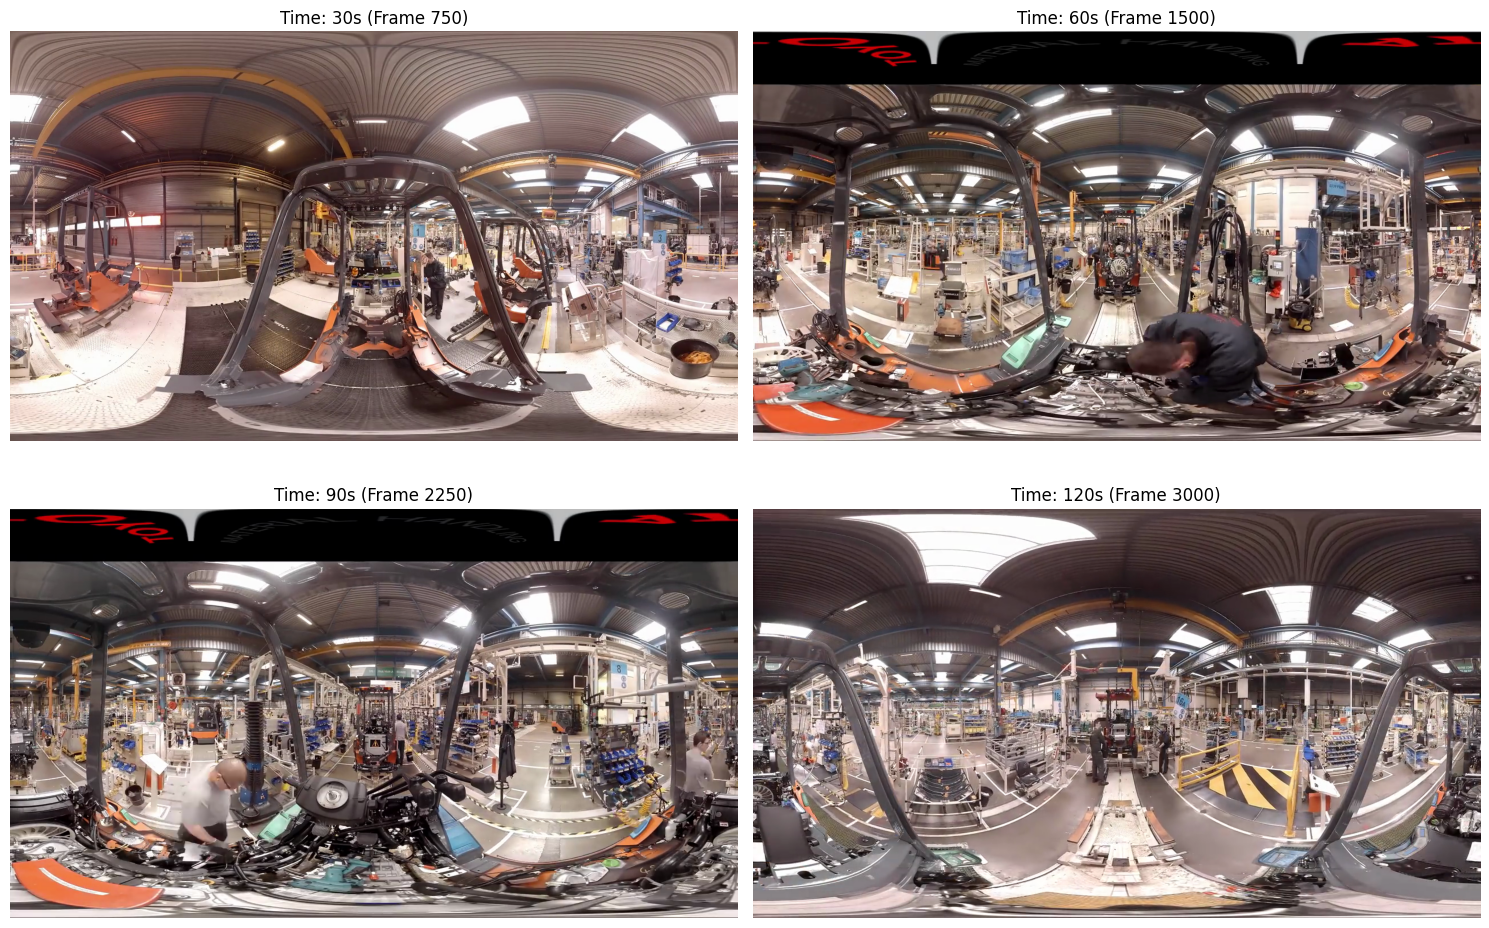

✅ Video content test complete!


In [8]:
# Quick Test: Sample from middle of video to find actual content
print("🔍 Testing video content at different time points...")

import cv2
import matplotlib.pyplot as plt

def test_video_at_timestamps(video_path, timestamps=[30, 60, 90, 120]):
    """Test video frames at specific timestamps"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, timestamp in enumerate(timestamps):
        frame_number = int(timestamp * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        
        if ret:
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f'Time: {timestamp}s (Frame {frame_number})')
            axes[i].axis('off')
            
            # Check if frame has content (not all black)
            brightness = frame_rgb.mean()
            print(f"  Time {timestamp}s: Brightness = {brightness:.1f}")
        else:
            axes[i].text(0.5, 0.5, f'No frame at {timestamp}s', ha='center', va='center')
            axes[i].set_title(f'Time: {timestamp}s - ERROR')
    
    cap.release()
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Video content test complete!")

# Test the video at different time points
test_video_at_timestamps(VIDEO_PATH, [30, 60, 90, 120])